In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp

import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

from multiprocessing import Process, Manager
import time

%matplotlib widget

In [2]:
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

In [3]:
NPARALLEL=2

In [6]:
Lx = 6 * 12
Ly = Lx # int(Lx/2)

nu = 3

is_orthogonal=False
tautil = 1.2*np.exp( 1.0j* 4.0/9.0 * np.pi)
tautil1 = np.real(tautil)
tautil2 = np.imag(tautil)

tau = Ly/Lx * tautil

description="Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)+str(is_orthogonal)

xsrc=0
ysrc=0

In [7]:
ell_tri = np.loadtxt("../data/"+description+"ell.dat", delimiter=",")
kappa = np.loadtxt("../data/"+description+"kappa.dat", delimiter=",")
ellstar = np.loadtxt("../data/"+description+"ellstar.dat", delimiter=",")
e = np.loadtxt("../data/"+description+"e.dat", delimiter=",")

In [8]:
# Ell=np.sqrt(np.array([
#     ell_tri[0,0]**2 + ell_tri[0,1]**2,
#     ell_tri[1,0]**2 + ell_tri[1,1]**2,
#     ell_tri[2,0]**2 + ell_tri[2,1]**2
# ]))

# Ellstar=np.sqrt(np.array([
#     ellstar[0,0]**2 + ellstar[0,1]**2,
#     ellstar[1,0]**2 + ellstar[1,1]**2,
#     ellstar[2,0]**2 + ellstar[2,1]**2
# ]))

# Ellx = ellstar[1]-ellstar[0]+ellstar[2]-ellstar[0]
# Elly = ellstar[2]-ellstar[0]+ellstar[2]-ellstar[1]

# AEllx = np.sqrt( Ellx[0]*Ellx[0] + Ellx[1]*Ellx[1] )
# AElly = np.sqrt( Elly[0]*Elly[0] + Elly[1]*Elly[1] )

In [9]:
# alpha01 = np.pi-np.arccos( e[0]@e[1] )
# alpha12 = np.pi-np.arccos( e[1]@e[2] )
# alpha20 = np.pi-np.arccos( e[2]@e[0] )
# alpha01, alpha12, alpha20 

# t0 = kappa[0] * np.cos( 0.5*alpha01 ) * np.cos( 0.5*alpha20 ) / np.cos( 0.5*alpha12 )
# t1 = kappa[1] * np.cos( 0.5*alpha12 ) * np.cos( 0.5*alpha01 ) / np.cos( 0.5*alpha20 )
# t2 = kappa[2] * np.cos( 0.5*alpha20 ) * np.cos( 0.5*alpha12 ) / np.cos( 0.5*alpha01 )

# gamma0 = t0/( kappa[0]*(1.0-t0**2) )
# gamma1 = t1/( kappa[1]*(1.0-t1**2) )
# gamma2 = t2/( kappa[2]*(1.0-t2**2) )

In [10]:
mat0 = np.array([
    [kappa[0], kappa[1], kappa[2]],
    [kappa[0]*e[0][0], kappa[1]*e[1][0], kappa[2]*e[2][0]],
    [kappa[0]*e[0][1], kappa[1]*e[1][1], kappa[2]*e[2][1]]
])

c=0.0

tilde_ell0 = np.linalg.inv(mat0)@np.array([c, 1.0, 0.0])
tilde_ell1 = np.linalg.inv(mat0)@np.array([c, 0.0, 1.0])

tilde_ell_tmp = np.array([tilde_ell0, tilde_ell1]).T

dualshift = (tilde_ell_tmp[2] - tilde_ell_tmp[0] - tilde_ell_tmp[1])/2.0

tmp_tilde = tilde_ell_tmp[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

tilde_ell = tilde_ell_tmp / relative

In [11]:
Ell=np.sqrt(np.array([
    ell_tri[0,0]**2 + ell_tri[0,1]**2,
    ell_tri[1,0]**2 + ell_tri[1,1]**2,
    ell_tri[2,0]**2 + ell_tri[2,1]**2
]))

Ellx = tilde_ell[1]-tilde_ell[0]+tilde_ell[2]-tilde_ell[0]
Elly = tilde_ell[2]-tilde_ell[0]+tilde_ell[2]-tilde_ell[1]

AEllx = np.sqrt( Ellx[0]*Ellx[0] + Ellx[1]*Ellx[1] )
AElly = np.sqrt( Elly[0]*Elly[0] + Elly[1]*Elly[1] )

In [12]:
s = 0.5*( Ell[0]+Ell[1]+Ell[2] )
# Area_lat = np.sqrt( s*(s-Ell[0])*(s-Ell[1])*(s-Ell[2]) )

alat = 3.0 / AEllx / Lx
r = np.sqrt( s * alat )
# r = np.sqrt( alat )

Ntri = int(Lx*Ly * 2/3)

# optimalFit = [-0.146428, 0.900587]

alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

alphaM = [alA, alB, alC]
Lxeff = int(Lx*2/3)

In [13]:
# ell_x = ell_tri[1]-ell_tri[2]
# ell_y = -ell_tri[0]
# ell_x = ell_tri[1]-ell_tri[2]
# ell_y = -ell_tri[0]

# abstau = np.linalg.norm( ell_y ) / np.linalg.norm( ell_x ) * 1.5
# angletau = np.arccos( ell_x@ell_y / np.linalg.norm( ell_x ) / np.linalg.norm( ell_y ) )
# tau = abstau * np.exp( 1.0j*angletau )

# angle = np.arccos( np.dot( Ellx, Elly )/np.linalg.norm(Ellx)/np.linalg.norm(Elly) )
# tau = np.linalg.norm(Elly)/np.linalg.norm(Ellx) * (np.cos(angle) + 1.0j*np.sin(angle))

In [14]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-8):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:
        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [15]:
def theta_upto2(z, Tau, nmax=1e5, tol=1.0e-8):
    r0 = np.pi*1.0j/Tau
    s0 = np.exp( -r0*z**2 )

    r1 = np.pi*1.0j/Tau
    arr1 = np.full(2, 0)
    arr1[1]=1
    H1 = np.polynomial.hermite.Hermite( arr1 )

    r2 = np.pi*1.0j/Tau
    arr2 = np.full(3, 0)
    arr2[2]=1
    H2 = np.polynomial.hermite.Hermite( arr2 )

    coeff1 = H1( np.sqrt(r1)*z )
    exp1 = np.exp( -r1*z**2 )
    s1 = coeff1 * exp1

    coeff2 = H2( np.sqrt(r2)*z )
    exp2 = np.exp( -r2*z**2 )
    s2 = coeff2 * exp2

    s0_old = s0
    s1_old = s1
    s2_old = s2
    for ell in np.arange(1,nmax):
        Ellz = ell+z
        s0 += np.exp( -r0*Ellz**2 )

        Sr1Ellz = np.sqrt(r1)*Ellz
        coeff1 = H1( Sr1Ellz )
        exp1 = np.exp( -Sr1Ellz**2 )
        s1 += coeff1 * exp1

        Sr2Ellz = np.sqrt(r2)*Ellz
        coeff2 = H2( Sr2Ellz )
        exp2 = np.exp( -Sr2Ellz**2 )
        coeff2 = H2( np.sqrt(r2)*(ell+z) )
        s2 += coeff2 * exp2

        mEllz = -ell+z
        s0 += np.exp( -r0*mEllz**2 )

        Sr1mEllz = np.sqrt(r1)*mEllz
        coeff1 = H1( Sr1mEllz )
        exp1 = np.exp( -Sr1mEllz**2 )
        s1 += coeff1 * exp1

        Sr2mEllz = np.sqrt(r2)*mEllz
        coeff2 = H2( Sr2mEllz )
        exp2 = np.exp( -Sr2mEllz**2 )
        s2 += coeff2 * exp2

        if np.abs(s2-s2_old)<tol: break
        s1_old = s1
        s2_old = s2
        if ell==nmax-1: 
            print("did not converge for z = ", z)
            return np.nan
            assert(False)

    coeff0 = 1.0 / np.sqrt(-1.0j*Tau)
    coeff1 = -coeff0 * np.sqrt(r1)
    coeff2 = coeff0 * r2
 
    th_d0 = coeff0 * s0 
    th_d1 = coeff1 * s1
    th_d2 = coeff2 * s2 

    return th_d0, th_d1, th_d2

In [16]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*z
    coeff = np.exp( 1.0j*im )

    return coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)


def th1_upto2(z):
    tmp0, tmp1, tmp2 = theta_upto2(z+0.5*tau+0.5, tau)

    s0 = tmp0
    s1 = np.pi*1.0j*tmp0 + tmp1
    s2 = -np.pi**2*tmp0 + 2.0*np.pi*1.0j*tmp1 + tmp2

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s0, -coeff * s1, -coeff * s2


def th2_upto2(z):
    tmp0, tmp1, tmp2 = theta_upto2(z+0.5*tau, tau)

    s0 = tmp0
    s1 = np.pi*1.0j*tmp0 + tmp1
    s2 = -np.pi**2*tmp0 + 2.0*np.pi*1.0j*tmp1 + tmp2

    im = 0.25*np.pi*tau + np.pi*z
    coeff = np.exp( 1.0j*im )

    return coeff * s0, coeff * s1, coeff * s2


def th3_upto2(z):
    return theta_upto2(z, tau)

def th4_upto2(z):
    return theta_upto2(z+0.5, tau)

In [17]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

In [18]:
def zeta(z):
    return th1(z,1)/th1(z) + 2.0*eta1*z

def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [19]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 
                         - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

In [20]:
def TTconn3(z):
    th1z, th1z1, th1z2 = th1_upto2( z )
    th3z, th3z1, th3z2 = th3_upto2( z )

    P3z = th1p0/th30 * th3z/th1z
    dP3z = th1p0/th30 * ( th3z1/th1z - th3z*th1z1/th1z**2 )
    ddP3z = th1p0/th30 * ( th3z2/th1z - 2.0*th3z1*th1z1/th1z**2 - th3z*th1z2/th1z**2 + 2.0*th3z*th1z1**2/th1z**3 )
    
    return -0.25 * ( dP3z**2 - ddP3z*P3z )

# def TTconn_(z):
#     return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

# TTconn3(zz), TTconn_(zz) 

# zz=0.1+0.1j
# import time

# start = time.time()
# [TTconn3(zz) for i in range(100)]
# # [TTconn_(zz) for i in range(100)]
# end = time.time()
# print(end - start)

In [21]:
def Dth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    return s

def Dth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z)
    s += 0.5*coeff * th3(z+0.5*tau, 1)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    return s

def Dth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 2)

def Dth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 2)

def dDth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z, 1)
    s -= 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 2)
    s -= np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 3)
    return s

def dDth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z, 1)
    s += 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau, 1)
    s += 0.5*coeff * th3(z+0.5*tau, 2)
    s += np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 3)
    return s

def dDth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 3)

def dDth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 3)

def DP2(z):
    tmp1 = dDth1(0)/th20 * th2(z)/th1(z)
    tmp2 = -th1p0*Dth2(0)/th20**2 * th2(z)/th1(z)
    tmp3 = th1p0/th20 * Dth2(z)/th1(z)
    tmp4 = -th1p0/th20 * th2(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP3(z):
    tmp1 = dDth1(0)/th30 * th3(z)/th1(z)
    tmp2 = -th1p0*Dth3(0)/th30**2 * th3(z)/th1(z)
    tmp3 = th1p0/th30 * Dth3(z)/th1(z)
    tmp4 = -th1p0/th30 * th3(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP4(z):
    tmp1 = dDth1(0)/th40 * th4(z)/th1(z)
    tmp2 = -th1p0*Dth4(0)/th40**2 * th4(z)/th1(z)
    tmp3 = th1p0/th40 * Dth4(z)/th1(z)
    tmp4 = -th1p0/th40 * th4(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

In [22]:
def Tepseps2_analytic(w0, w1, w2):

    p = P2(w1-w2)
    cp = np.conj(P2(w1-w2))
    dp = dP2(w1-w2)
    Dp = DP2(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e1 * epseps
    
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps3_analytic(w0, w1, w2):

    p = P3(w1-w2)
    cp = np.conj(P3(w1-w2))
    dp = dP3(w1-w2)
    Dp = DP3(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e2 * epseps
    
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps4_analytic(w0, w1, w2):

    p = P4(w1-w2)
    cp = np.conj(P4(w1-w2))
    dp = dP4(w1-w2)
    Dp = DP4(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e3 * epseps
    
#    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

In [23]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

## Generate lattice

In [24]:
Ntot = Lx*Ly

In [25]:
dualshift = (tilde_ell[2] - tilde_ell[0] - tilde_ell[1])/2.0

tmp_tilde = tilde_ell[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

In [26]:
# pts_ = []
# ppts_ = []
# pppts_ = []

# for yc in range(Ly):
#     if yc==0:
#         pts_.append( [ 0, 0, 0, 0, 0 ] )
#     else:
#         prev = pts_[-Lx]
#         if yc%3==1 or yc%3==0:
#             pts_.append( [0, yc, prev[2]-0.5*ell_tri[0][0]-0.5*ellstar[0][0], prev[3]-0.5*ell_tri[0][1]-0.5*ellstar[0][1], 2*(yc%3)] )
#         else:
#             pts_.append( [0, yc, prev[2]+ellstar[2][0], prev[3]+ellstar[2][1], 1] )
    
#     if pts_[-1][4]!=0:
#         ppts_.append( pts_[-1] )
#         if (ppts_[-1][0]-xsrc)**2+(ppts_[-1][1]-ysrc)**2<2**2:
#             pppts_.append( pts_[-1] )
            
#     for xp in range(Lx-1):
#         prev = pts_[-1]
#         c = (xp-yc + Ntot)%3
#         if c==0:
#             pts_.append( [xp+1, yc, prev[2]-0.5*ell_tri[2][0]+0.5*ellstar[2][0], prev[3]-0.5*ell_tri[2][1]+0.5*ellstar[2][1], 1] )
#         elif c==1:
#             pts_.append( [xp+1, yc, prev[2]-ellstar[0][0], prev[3]-ellstar[0][1], 2 ] )
#         else:
#             pts_.append( [xp+1, yc, prev[2]+0.5*ell_tri[1][0]+0.5*ellstar[1][0], prev[3]+0.5*ell_tri[1][1]+0.5*ellstar[1][1], 0 ] )
        
#         if pts_[-1][4]!=0:
#             ppts_.append( pts_[-1] )
#             if (ppts_[-1][0]-xsrc)**2+(ppts_[-1][1]-ysrc)**2<2**2:
#                 pppts_.append( pts_[-1] )

# pts = np.array( pts_ )
# ppts = np.array( ppts_ )
# pppts = np.array( pppts_ )

# pts.T[2] *= alat
# pts.T[3] *= alat

# ppts.T[2] *= alat
# ppts.T[3] *= alat

# pppts.T[2] *= alat
# pppts.T[3] *= alat

In [27]:
pts_ = []
ppts_ = []

for yc in range(Ly):
    if yc==0:
        pts_.append( [ 0, 0, 0, 0, 0 ] )
    else:
        prev = pts_[-Lx]
        if yc%3!=1:
            pts_.append( [0, yc, 
                          prev[2]-0.5*ell_tri[0][0]*relative-0.5*tilde_ell[0][0], 
                          prev[3]-0.5*ell_tri[0][1]*relative-0.5*tilde_ell[0][1], 
                          (0-yc+Ntot)%3] )
        else:
            pts_.append( [0, yc, 
                          prev[2]+tilde_ell[2][0], 
                          prev[3]+tilde_ell[2][1], 
                          2] )
    
    if pts_[-1][4]!=1:
        ppts_.append( pts_[-1] )
            
    for xp in range(Lx-1):
        prev = pts_[-1]
        c = (xp-yc + Ntot)%3
        if c==1:
            pts_.append( [xp+1, yc, 
                          prev[2]-0.5*ell_tri[2][0]*relative+0.5*tilde_ell[2][0], 
                          prev[3]-0.5*ell_tri[2][1]*relative+0.5*tilde_ell[2][1], 
                          2] )
        elif c==2:
            pts_.append( [xp+1, yc, 
                          prev[2]-tilde_ell[0][0], 
                          prev[3]-tilde_ell[0][1], 
                          0 ] )
        else:
            pts_.append( [xp+1, yc, 
                          prev[2]+0.5*ell_tri[1][0]*relative+0.5*tilde_ell[1][0], 
                          prev[3]+0.5*ell_tri[1][1]*relative+0.5*tilde_ell[1][1], 
                          1 ] )
        
        if pts_[-1][4]!=1:
            ppts_.append( pts_[-1] )

pts = np.array( pts_ )
ppts = np.array( ppts_ )

pts.T[2] *= alat
pts.T[3] *= alat

ppts.T[2] *= alat
ppts.T[3] *= alat

In [28]:
type0_=[]
type1_=[]
type2_=[]
for pt in pts:
    if pt[-1]==0: type0_.append( pt )
    elif pt[-1]==1: type1_.append( pt )
    elif pt[-1]==2: type2_.append( pt )

In [29]:
type0 = np.array(type0_)
type1 = np.array(type1_)
type2 = np.array(type2_)

(-0.01, 0.1)

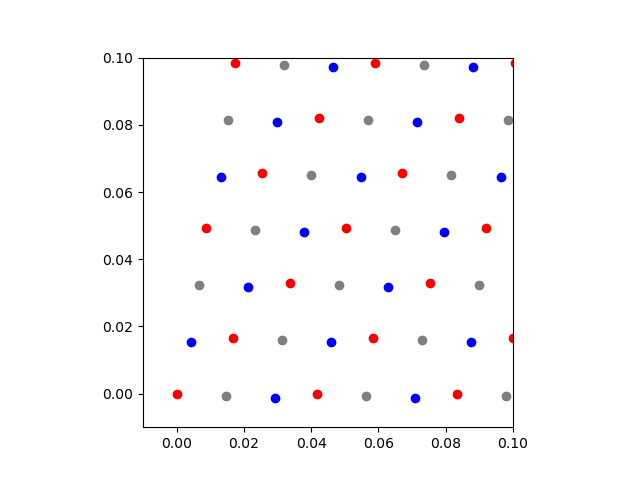

In [30]:
plt.close()
plt.plot( type0.T[2], type0.T[3], ls="none", marker="o", color='red' )
plt.plot( type1.T[2], type1.T[3], ls="none", marker="o", color='gray' )
plt.plot( type2.T[2], type2.T[3], ls="none", marker="o", color='blue' )
plt.gca().set_aspect('equal')
plt.xlim(-0.01, 0.1)
plt.ylim(-0.01, 0.1)

(-0.01, 0.1)

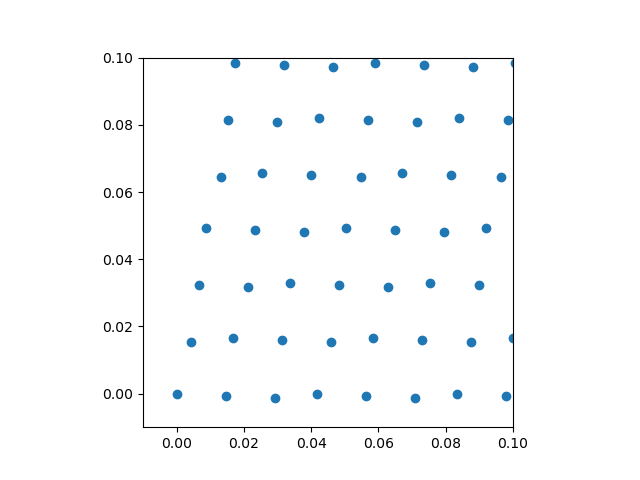

In [31]:
plt.close()
plt.plot( pts.T[2], pts.T[3], ls="none", marker="o" )
plt.gca().set_aspect('equal')
plt.xlim(-0.01, 0.1)
plt.ylim(-0.01, 0.1)

In [32]:
# isrc=xsrc+Lx*ysrc
# src = np.array([ pts[isrc][2], pts[isrc][3] ])
# src_cplx = src[0]+1.0j*src[1]

In [33]:
xlat_ = []
ylat_ = []
for i in range(Ntot):
    if np.abs(pts[i][-1])!=1:
        xlat_.append( pts[i][2] )
        ylat_.append( pts[i][3] )
xlat = np.array(xlat_)
ylat = np.array(ylat_)

In [34]:
def getSiteXY():
    # type2Shifted = np.array( [type2.T[2], type2.T[3] ] ).T + Delta*alat
    res_ = []
    for i in range(type0.shape[0]):
        if type0[i][2]<type2[i][2]:
            res_.append( [type0[i][2], type0[i][3]] )
            res_.append( [type2[i][2], type2[i][3]] )
        else:
            res_.append( [type2[i][2], type2[i][3]] )
            res_.append( [type0[i][2], type0[i][3]] )
    res = np.array(res_)
    return res

In [35]:
font = {'size'   : 12}
plt.rc('font', **font)

colors={
    2:'#006BA4',
    3:'#FF800E',
    4:'#ABABAB',
    "A":'#FFBC79',
    "B":'#5F9ED1',
    "C":'#C85200',
    6:'#898989',
    7:'#A2C8EC',
    8:'#595959',
    9:'#CFCFCF'
}

markers={
    2:"o", 
    3:"d", 
    4:"v", 
    "A":"x", 
    "B":"<", 
    "C":"^", 
}

## Z

In [33]:
# description1="Lx"+str(Lx)+"Ly"+str(Ly)+"nu1tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)
description2="Lx"+str(Lx)+"Ly"+str(Ly)+"nu2tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)
description3="Lx"+str(Lx)+"Ly"+str(Ly)+"nu3tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)
description4="Lx"+str(Lx)+"Ly"+str(Ly)+"nu4tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)

# logabsdet1= np.loadtxt("../data/"+description1+"logabsdet.dat")
logabsdet2= np.loadtxt("../data/"+description2+"logabsdet.dat")[1]
logabsdet3= np.loadtxt("../data/"+description3+"logabsdet.dat")[1]
logabsdet4= np.loadtxt("../data/"+description4+"logabsdet.dat")[1]

FileNotFoundError: ../data/Lx72Ly72nu2tautil0.208378_1.181769logabsdet.dat not found.

In [ ]:
logabsdet2

In [ ]:
# 9*12
Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
Z3 = 1.0
Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )

In [ ]:
Z2/Z3

In [ ]:
LogRZ2 = 0.5* (logabsdet2-np.log(ZM(2)**2) )
LogRZ3 = 0.5* (logabsdet3-np.log(ZM(3)**2) )
LogRZ4 = 0.5* (logabsdet4-np.log(ZM(4)**2) )

In [ ]:
ZM(2), ZM(3)

In [57]:
ZM(4)/ZM(3)

0.8564528717280393

In [62]:
LogRZ2, LogRZ3, LogRZ4

(267.68142743120575, 267.5750074813997, 267.8398497291608)

In [63]:
tau

(2.453250305746017e-16+0.8660254037844384j)

In [64]:
[np.log(s*alat), np.real(tau), np.imag(tau), LogRZ2]

[-3.832720490339826,
 2.453250305746017e-16,
 0.8660254037844384,
 267.68142743120575]

In [65]:
data=np.array([
    [-3.743338462140677, 0.17364817766693041, 0.984807753012208, 253.17073942310992],
    [-3.7634181161499196, 0.25881904510252074, 0.9659258262890683, 259.0284871655648],
    [-3.785055761094982, 0.3420201433256688, 0.9396926207859083, 263.59886140157244],
    [-3.8081879116458817, 0.42261826174069944, 0.9063077870366499, 266.6051973325414],
    [-3.832720490339826, 0.5000000000000001, 0.8660254037844386, 267.6987615472545],
    # [-3.8853873765285405, 0.6427876096865394, 0.766044443118978, 262.30459081191066],
])

In [66]:
 data.T[0][:-1]

array([-3.74333846, -3.76341812, -3.78505576, -3.80818791])

In [67]:
np.arccos( data.T[1] )

array([1.3962634 , 1.30899694, 1.22173048, 1.13446401, 1.04719755])

In [68]:
np.arccos( data.T[1] ) / np.exp(data.T[0])

array([58.97644529, 56.41185123, 53.80272079, 51.12881418, 48.36798305])

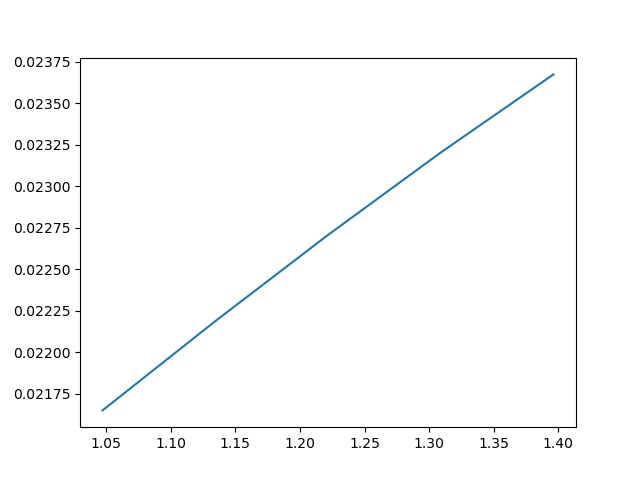

In [69]:
plt.close()
plt.plot( np.arccos( data.T[1] ), np.exp(data.T[0]) )

Text(0, 0.5, '$\\log \\tilde{Z}_\\xi-\\log {Z}$')

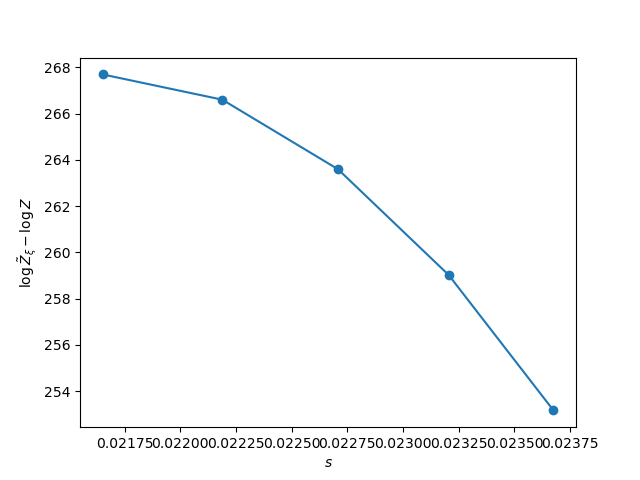

In [70]:
plt.close()
plt.plot( np.exp(data.T[0]), data.T[3], marker="o" )

plt.xlabel("$s$")
plt.ylabel("$\\log \\tilde{Z}_\\xi-\\log {Z}$")

[10023.871494157136, (0.17364817766693041+0.984807753012208j), (253.17073942310992, 253.1707032319828, 253.17073942310878)
9623.385424195818, (0.3420201433256688+0.9396926207859083j), (263.59886140157244, 263.5988436283112, 263.5988614015685)
9165.804023445304, (0.5000000000000001+0.8660254037844386j), (267.6987615472545, 267.69876154725586, 267.69876154725586)

In [71]:
(9623.385424195818 - 9165.804023445304)/(267.6987615472545 - 263.59886140157244)

111.607937874397

In [72]:
267.6987615472545 - 263.59886140157244

4.0999001456820565

## $\psi \psi$ correlator

In [32]:
xixi00 = np.loadtxt("../data/"+description+"xixi00.dat")
xixi01 = np.loadtxt("../data/"+description+"xixi01.dat")
xixi10 = np.loadtxt("../data/"+description+"xixi10.dat")
xixi11 = np.loadtxt("../data/"+description+"xixi11.dat")

$$
\langle \xi_{O,i} \xi_{P,j} \rangle
=
-{D^{-1}_{P,j}}^{O,k} \epsilon_{ki}
$$
or
$$
{D^{-1}_{P,j}}^{O,k} 
=
\langle \xi_{P,j} \xi_{O,i} \rangle
\epsilon^{ik}.
$$
Now that:
$$
\langle \xi_{P,j} \xi_{O,i} \rangle
=
r^2 
\langle \psi_{P,j} \psi_{O,i} \rangle
$$

In [33]:
xs = xixi00.T[0][:int(2*Lx/3)]
ys = xixi00.T[1][::int(2*Lx/3)]

In [35]:
etaeta_analytic=np.array([ [elem[2], elem[3], P3(elem[2]+1.0j*elem[3])] for elem in pts] )

$$
(2\pi/r^2){D^{-1}_{P,0}}^{O,1} 
=
2\pi
\langle \psi_{P,0} \psi_{O,0} \rangle
\epsilon^{01}
=
\frac{1}{z}.
$$

In [36]:
eta = dedekind( tau )

In [37]:
Neff = int(Ntot*2/3)

In [38]:
tmpx = xixi01.T[0]
tmpy = xixi01.T[1]
tmpzr = xixi01.T[2]
tmpzi = xixi01.T[3]
res_ = []

for i in range(Neff):
    res_.append( [ xlat[i], ylat[i], 2.0*np.pi*(tmpzr[i]+1.0j*tmpzi[i])/r**2 ] )
etaeta = np.array(res_)

In [39]:
tmpx = xixi00.T[0]
tmpy = xixi00.T[1]
tmpzr = xixi00.T[2]
tmpzi = xixi00.T[3]
res_ = []

for i in range(Neff):
    res_.append( [ xlat[i], ylat[i], 2.0*np.pi*(tmpzr[i]+1.0j*tmpzi[i])/r**2 ] )
etaetabar = np.array(res_)

In [40]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=-90)

# ax.scatter(etaetabar.T[0], etaetabar.T[1], np.log(np.real(etaetabar.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaetabar.T[0], etaetabar.T[1], np.log(-np.real(etaetabar.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.set_xlabel("$\sigma_1$")
# ax.set_ylabel("$\sigma_2$")

# ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=-90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# # ax.set_

# #################

# fig.tight_layout()

# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_9986/1474567140.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.real(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_9986/1474567140.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.real(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_9986/1474567140.py:23: RuntimeWar

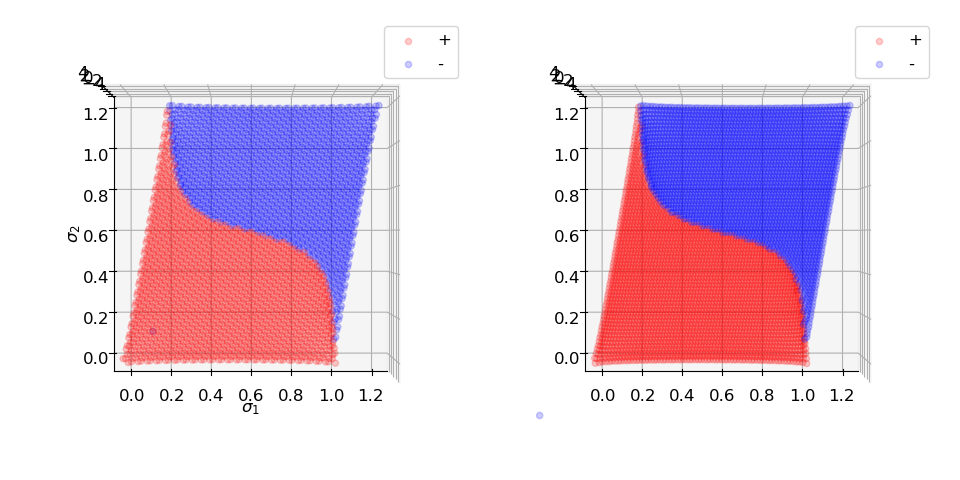

In [41]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.real(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.real(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.set_xlabel("$\sigma_1$")
ax.set_ylabel("$\sigma_2$")

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

# ax.set_

#################

fig.tight_layout()

# plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_9986/589681969.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_9986/589681969.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_9986/589681969.py:20: RuntimeWarning: invalid value encountered in log
  np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_9986/589681969.py:22: RuntimeWarning: invalid value encountered in log
  np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)


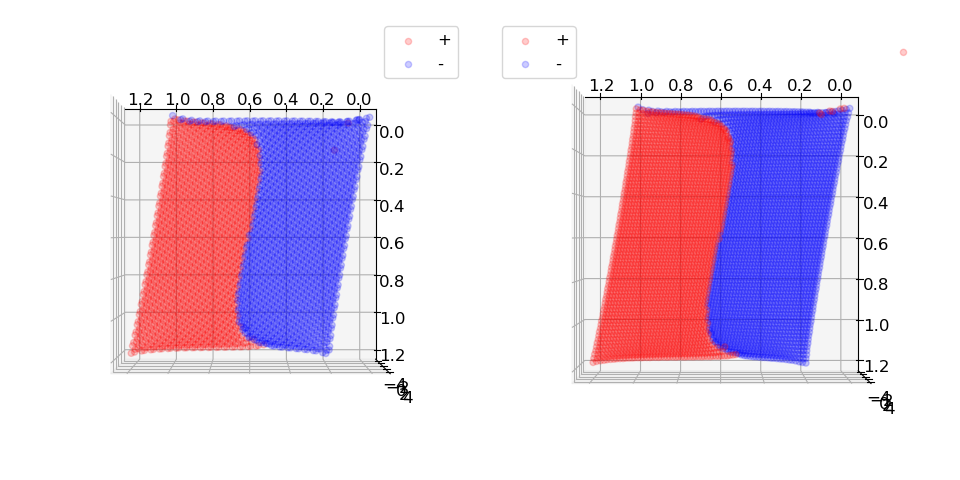

In [42]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################
ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)
ax.set_aspect("equal")

ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

fig.tight_layout()

# plt.savefig('../plt/im_xixi_above.pdf',bbox_inches='tight')

In [43]:
tau

(0.20837781320031648+1.1817693036146495j)

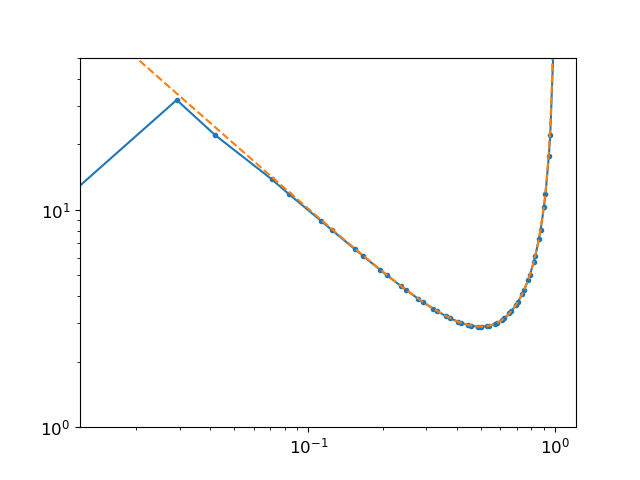

In [44]:
plt.close()

t=0

plt.plot( 
    etaeta.T[0][t*int(Lx*2/3):(t+1)*int(Lx*2/3)], 
    # etaeta.T[2][:int(Lx*2/3)] / rel**8,
    etaeta.T[2][t*int(Lx*2/3):(t+1)*int(Lx*2/3)],
    label="numeric", marker='.'
        )

# plt.plot(
#     xxxx[t*int(Lx*2/3):(t+1)*int(Lx*2/3)], 
#     etaeta.T[2][t*int(Lx*2/3):(t+1)*int(Lx*2/3)],
#     label="numeric", marker='x'
#         )

plt.plot(
    etaeta_analytic.T[0][t*int(Lx):(t+1)*int(Lx)], 
    etaeta_analytic.T[2][t*int(Lx):(t+1)*int(Lx)],
    label="analytic", 
    ls="dashed"
)

plt.yscale("log")
plt.xscale("log")

plt.ylim(1.0e0, 5.0e1)

plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

In [45]:
# plt.close()

# t=0

# plt.plot( 
#     etaetabar.T[0][t*int(Lx*2/3):(t+1)*int(Lx*2/3)], 
#     # etaeta.T[2][:int(Lx*2/3)] / rel**8,
#     etaetabar.T[2][t*int(Lx*2/3):(t+1)*int(Lx*2/3)],
#     label="numeric", marker='.'
#         )

# # plt.plot(
# #     xxxx[t*int(Lx*2/3):(t+1)*int(Lx*2/3)], 
# #     etaeta.T[2][t*int(Lx*2/3):(t+1)*int(Lx*2/3)],
# #     label="numeric", marker='x'
# #         )

# plt.plot(
#     etaeta_analytic.T[0][t*int(Lx):(t+1)*int(Lx)], 
#     etaeta_analytic.T[2][t*int(Lx):(t+1)*int(Lx)],
#     label="analytic", 
#     ls="dashed"
# )

# plt.yscale("log")
# plt.xscale("log")

# plt.ylim(1.0e-5, 5.0e1)

# plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

# $\epsilon\epsilon$

In [46]:
eps = np.loadtxt("../data/"+description+"eps_corr.dat")

In [47]:
epseps_analytic=np.array([ [elem[2], elem[3], np.abs( P3(elem[2]+1.0j*elem[3]) )**2 ] for elem in pts] )

In [48]:
tmpx = eps.T[0]
tmpy = eps.T[1]
tmpzr = eps.T[2]
tmpzi = eps.T[3]
res_ = []

for i in range(len(eps.T[0])):
    res_.append( [ xlat[i], ylat[i], (2.0*np.pi)**2 * (tmpzr[i]+1.0j*tmpzi[i])/r**4 ] )
epseps = np.array(res_)

/tmp/ipykernel_9986/749003900.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_9986/749003900.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_9986/749003900.py:22: RuntimeWarnin

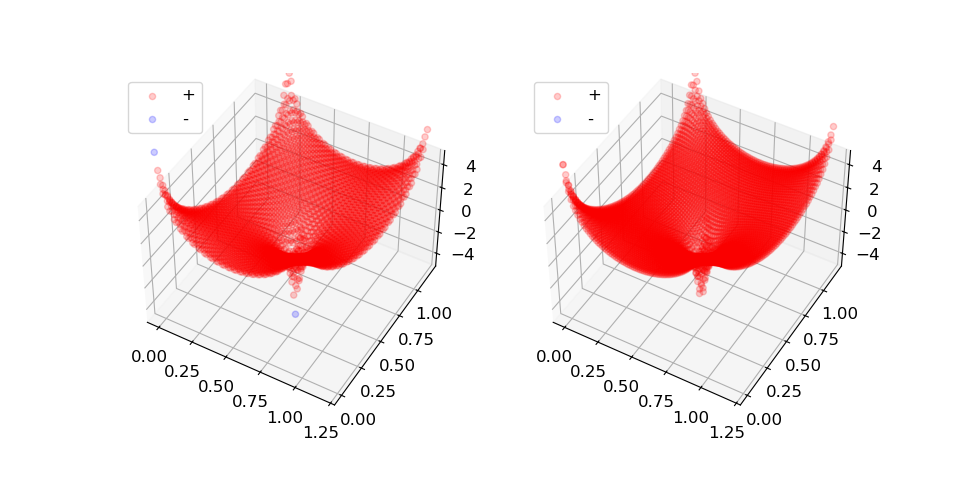

In [49]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(epseps_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(-epseps_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

# #################

# fig.tight_layout()

# plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_9986/1899699433.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 5.0e5)


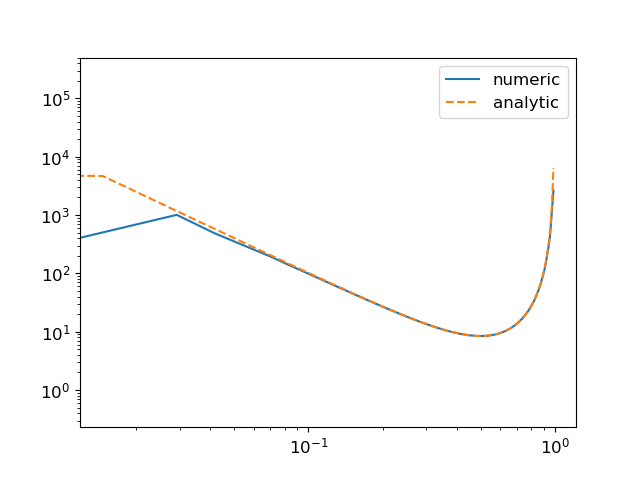

In [50]:
plt.close()

plt.plot( 
    epseps.T[0][:int(2*Lx/3)], 
    epseps.T[2][:int(2*Lx/3)],
#    epseps.T[2][:int(2*Lx/3)] / rel**16,
    label="numeric"
        )

plt.plot(
    epseps_analytic.T[0][:int(Lx)],
    epseps_analytic.T[2][:int(Lx)],
    label="analytic", 
    ls="dashed"
)

plt.yscale("log")
plt.legend()

plt.ylim(0, 5.0e5)

plt.xscale("log")
plt.yscale("log")

# plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

# $TT$ v2

In [51]:
K0K0 = np.loadtxt("../data/"+description+"K0K0.dat")
K0K1 = np.loadtxt("../data/"+description+"K0K1.dat")
K0K2 = np.loadtxt("../data/"+description+"K0K2.dat")
#
K1K0 = np.loadtxt("../data/"+description+"K1K0.dat")
K1K1 = np.loadtxt("../data/"+description+"K1K1.dat")
K1K2 = np.loadtxt("../data/"+description+"K1K2.dat")
#
K2K0 = np.loadtxt("../data/"+description+"K2K0.dat")
K2K1 = np.loadtxt("../data/"+description+"K2K1.dat")
K2K2 = np.loadtxt("../data/"+description+"K2K2.dat")

##

K0E = np.loadtxt("../data/"+description+"K0E.dat")
K1E = np.loadtxt("../data/"+description+"K1E.dat")
K2E = np.loadtxt("../data/"+description+"K2E.dat")
#
K0E0 = np.loadtxt("../data/"+description+"K0E0.dat")
K1E0 = np.loadtxt("../data/"+description+"K1E0.dat")
K2E0 = np.loadtxt("../data/"+description+"K2E0.dat")
#
K0E1 = np.loadtxt("../data/"+description+"K0E1.dat")
K1E1 = np.loadtxt("../data/"+description+"K1E1.dat")
K2E1 = np.loadtxt("../data/"+description+"K2E1.dat")
#
K0E2 = np.loadtxt("../data/"+description+"K0E2.dat")
K1E2 = np.loadtxt("../data/"+description+"K1E2.dat")
K2E2 = np.loadtxt("../data/"+description+"K2E2.dat")

##
EK0 = np.loadtxt("../data/"+description+"EK0.dat")
EK1 = np.loadtxt("../data/"+description+"EK1.dat")
EK2 = np.loadtxt("../data/"+description+"EK2.dat")
#
E0K0 = np.loadtxt("../data/"+description+"E0K0.dat")
E0K1 = np.loadtxt("../data/"+description+"E0K1.dat")
E0K2 = np.loadtxt("../data/"+description+"E0K2.dat")
#
E1K0 = np.loadtxt("../data/"+description+"E1K0.dat")
E1K1 = np.loadtxt("../data/"+description+"E1K1.dat")
E1K2 = np.loadtxt("../data/"+description+"E1K2.dat")
#
E2K0 = np.loadtxt("../data/"+description+"E2K0.dat")
E2K1 = np.loadtxt("../data/"+description+"E2K1.dat")
E2K2 = np.loadtxt("../data/"+description+"E2K2.dat")

##

E0E = np.loadtxt("../data/"+description+"E0E.dat")
E1E = np.loadtxt("../data/"+description+"E1E.dat")
E2E = np.loadtxt("../data/"+description+"E2E.dat")
#
EE0 = np.loadtxt("../data/"+description+"EE0.dat")
EE1 = np.loadtxt("../data/"+description+"EE1.dat")
EE2 = np.loadtxt("../data/"+description+"EE2.dat")
#
EE = np.loadtxt("../data/"+description+"EE.dat")

##

E0E0 = np.loadtxt("../data/"+description+"E0E0.dat")
E0E1 = np.loadtxt("../data/"+description+"E0E1.dat")
E0E2 = np.loadtxt("../data/"+description+"E0E2.dat")
#
E1E0 = np.loadtxt("../data/"+description+"E1E0.dat")
E1E1 = np.loadtxt("../data/"+description+"E1E1.dat")
E1E2 = np.loadtxt("../data/"+description+"E1E2.dat")
#
E2E0 = np.loadtxt("../data/"+description+"E2E0.dat")
E2E1 = np.loadtxt("../data/"+description+"E2E1.dat")
E2E2 = np.loadtxt("../data/"+description+"E2E2.dat")

In [52]:
Tn0Tn0 = K0K0 - 0.5*(K0E+K0E0) - 0.5*(EK0+E0K0) + 0.25*(EE+EE0+E0E+E0E0)
Tn0Tn1 = K0K1 - 0.5*(K0E+K0E1) - 0.5*(EK1+E0K1) + 0.25*(EE+EE1+E0E+E0E1)
Tn0Tn2 = K0K2 - 0.5*(K0E+K0E2) - 0.5*(EK2+E0K2) + 0.25*(EE+EE2+E0E+E0E2)

Tn1Tn0 = K1K0 - 0.5*(K1E+K1E0) - 0.5*(EK0+E1K0) + 0.25*(EE+EE0+E1E+E1E0)
Tn1Tn1 = K1K1 - 0.5*(K1E+K1E1) - 0.5*(EK1+E1K1) + 0.25*(EE+EE1+E1E+E1E1)
Tn1Tn2 = K1K2 - 0.5*(K1E+K1E2) - 0.5*(EK2+E1K2) + 0.25*(EE+EE2+E1E+E1E2)

Tn2Tn0 = K2K0 - 0.5*(K2E+K2E0) - 0.5*(EK0+E2K0) + 0.25*(EE+EE0+E2E+E2E0)
Tn2Tn1 = K2K1 - 0.5*(K2E+K2E1) - 0.5*(EK1+E2K1) + 0.25*(EE+EE1+E2E+E2E1)
Tn2Tn2 = K2K2 - 0.5*(K2E+K2E2) - 0.5*(EK2+E2K2) + 0.25*(EE+EE2+E2E+E2E2)

In [53]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

alphaM = [alA, alB, alC]
alphaM

[-2.899658705433039, -0.7965302858696379, 0.9876960458870854]

In [55]:
# params1init = [-(np.pi+alA)/2.0, Ellstar[0]]

# Lxeff = int(Lx*2/3)
# i_contact=[
#     0, 
#     Lxeff-1, Lxeff*Ly-1, 2*Lxeff-1,
#     Lxeff*(Ly-1), Lxeff*(Ly-2)+1, Lxeff*(Ly-1)+1,
#     Lxeff, Lxeff+1, 3*Lxeff-1
# ]

# i_contact2=[
#     0, 
#     Lx-1, Lx*Ly-1, 2*Lx-2,
#     Lx*(Ly-1)+1, Lx*(Ly-2)+1, Lx*(Ly-1)+1,
#     Lx, Lx+1, 3*Lx-1
# ]

# i_contact3=((np.array([
#     0, 
#     Lxeff*Ly-1, 2*Lxeff-1,
#     Lxeff*(Ly-2)+1, Lxeff*(Ly-1)+1,
#     Lxeff+1, 3*Lxeff-1
# ]) -1 )/2 ).astype(int)

# # ii=9
# # print( shifted[i_contact[ii]] )
# # print( pts[i_contact2[ii] ] )

In [56]:
# params1init = [-(np.pi+alA)/2.0, Ellstar[0]]

Lxeff = int(Lx*2/3)
# i_contact=[0,1,Lxeff-1,Lxeff,2*Lxeff-1,2*Lxeff,2*Lxeff+1,3*Lxeff-1,4*Lxeff-1]

In [57]:
def mixing(x, theta_ ):
    return np.cos(theta_)*x[0] - np.sin(theta_)*x[1]


def ArcTan( x, y ):
    tmp = np.arctan( y/x )
    if x<0:
        tmp += np.pi
    return tmp

In [59]:
tilde_ell

array([[-0.89647311, -0.08594939],
       [ 0.89514908, -1.26771869],
       [ 0.3119047 ,  1.09581992]])

In [60]:
def getLinkXY( A_, B_ ):
    # dalA, fact = params1_
    # tildeEllstar0 = fact * np.array([np.cos(alA+dalA), np.sin(alA+dalA)])
    # Delta = tildeEllstar0 - ellstar[0]
    # tildeEllstar1 = ellstar[1] + Delta
    # tildeEllstar2 = ellstar[2] + Delta

    shift1 = 0.0
    if A_==0: 
        shift1 = 0.5*tilde_ell[0]
    elif A_==1: 
        shift1 = 0.5*tilde_ell[1]
    elif A_==2: 
        shift1 = 0.5*tilde_ell[2]
    else: assert False

    shift2 = 0.0
    if B_==0: 
        shift2 = 0.5*tilde_ell[0]
    elif B_==1: 
        shift2 = 0.5*tilde_ell[1]
    elif B_==2: 
        shift2 = 0.5*tilde_ell[2]
    else: assert False

    return type0[:,[2,3]] + (-shift1 + shift2)*alat

In [61]:
# def getLinkXYShifted( params1_, A_, B_ ):
#     dalA, fact = params1_
#     tildeEllstar0 = fact * np.array([np.cos(alA+dalA), np.sin(alA+dalA)])
#     Delta = tildeEllstar0 - ellstar[0]
#     tildeEllstar1 = ellstar[1] + Delta
#     tildeEllstar2 = ellstar[2] + Delta

#     shift1 = 0.0
#     if A_==0: 
#         shift1 = 0.5*tildeEllstar0
#     elif A_==1: 
#         shift1 = 0.5*tildeEllstar1
#     elif A_==2: 
#         shift1 = 0.5*tildeEllstar2
#     else: assert False

#     shift2 = 0.0
#     if B_==0: 
#         shift2 = 0.5*tildeEllstar0
#     elif B_==1: 
#         shift2 = 0.5*tildeEllstar1
#     elif B_==2: 
#         shift2 = 0.5*tildeEllstar2
#     else: assert False

#     return type0[:,[2,3]] + (-shift1 + shift2)*alat

In [64]:
def parallel_TTconn3( rank_, returned_dict_, XYs_ ):
    returned_dict_[rank_] = np.array([TTconn3( elem[0]+1.0j*elem[1] ) for elem in XYs_[rank_::nproc]] )

nproc = NPARALLEL
assert np.shape(ppts)[0]%nproc==0

manager = Manager()
returned_dict = manager.dict()

def TTconnParallel( XYs_, returned_dict_ ):
    for i in range(nproc):
        process = Process(
            target=parallel_TTconn3,
            kwargs={
                'rank_': i,
                'returned_dict_': returned_dict_,
                'XYs_': XYs_
            })   
        process.start()
    process.join()

    res_ = []
    for i in range(nproc):
        res_.append( returned_dict_[i] )
    joined = np.array(res_).T.flatten()

    return joined

In [65]:
TTsOri = [
    [Tn0Tn0.T[2], Tn0Tn1.T[2], Tn0Tn2.T[2]],
    [Tn1Tn0.T[2], Tn1Tn1.T[2], Tn1Tn2.T[2]],
    [Tn2Tn0.T[2], Tn2Tn1.T[2], Tn2Tn2.T[2]]
]

In [448]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])
alphaM = [alA, alB, alC]

def ArcTan( x, y ):
    tmp = np.arctan( y/x )
    if x<0:
        tmp += np.pi
    return tmp

tildeAlA = ArcTan( tilde_ell[0][0], tilde_ell[0][1] )
tildeAlB = ArcTan( tilde_ell[1][0], tilde_ell[1][1] )
tildeAlC = ArcTan( tilde_ell[2][0], tilde_ell[2][1] )

tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

In [449]:
TildeEll = np.array([ 
    np.linalg.norm(tilde_ell[0]),
    np.linalg.norm(tilde_ell[1]), 
    np.linalg.norm(tilde_ell[2]) 
])

In [450]:
def mixing_routine( A_, B_, returned_dict_ ):
    # dalA, fact = params1_
    # tildeEllstar0 = fact * np.array([np.cos(alA+dalA), np.sin(alA+dalA)])
    
    # deltaEllstar0 = tildeEllstar0-ellstar[0]
    # tildeEllstar1 = ellstar[1] + deltaEllstar0
    # tildeEllstar2 = ellstar[2] + deltaEllstar0

    # TildeEllstar0 = np.linalg.norm( tilde_ell[0] )
    # TildeEllstar1 = np.linalg.norm( tilde_ell[1] )
    # TildeEllstar2 = np.linalg.norm( tilde_ell[2] )
    
    # tildeAlA = ArcTan( tildeEllstar0[0], tildeEllstar0[1] )
    # tildeAlB = ArcTan( tildeEllstar1[0], tildeEllstar1[1] )
    # tildeAlC = ArcTan( tildeEllstar2[0], tildeEllstar2[1] )
    # tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

    angle = alphaM[A_]+tildealphaM[A_] + alphaM[B_]+tildealphaM[B_]

    XY = getLinkXY( A_, B_ )
    tt_analy_ = TTconnParallel( XY, returned_dict_ )
    
    analy_mixed = 2.0 * mixing( [np.real(tt_analy_), np.imag(tt_analy_)], angle ) ### !!!@@@ FACTOR 2!?

    ZA = 1.0/(alat*TildeEll[0])
    ZB = 1.0/(alat*TildeEll[1])
    ZC = 1.0/(alat*TildeEll[2])

    Zs = [ ZA, ZB, ZC ]
    
    numeric_scaled = (2.0*np.pi)**2 * Zs[A_]*Zs[B_] * 1.0/r**4 * TTsOri[A_][B_]

    return XY, analy_mixed, numeric_scaled

In [74]:
# def mixing_routine( params1_, A_, B_, returned_dict_ ):
#     dalA, fact = params1_
#     tildeEllstar0 = fact * np.array([np.cos(alA+dalA), np.sin(alA+dalA)])
    
#     deltaEllstar0 = tildeEllstar0-ellstar[0]
#     tildeEllstar1 = ellstar[1] + deltaEllstar0
#     tildeEllstar2 = ellstar[2] + deltaEllstar0
    
#     TildeEllstar0 = np.linalg.norm( tildeEllstar0 )
#     TildeEllstar1 = np.linalg.norm( tildeEllstar1 )
#     TildeEllstar2 = np.linalg.norm( tildeEllstar2 )
    
#     tildeAlA = ArcTan( tildeEllstar0[0], tildeEllstar0[1] )
#     tildeAlB = ArcTan( tildeEllstar1[0], tildeEllstar1[1] )
#     tildeAlC = ArcTan( tildeEllstar2[0], tildeEllstar2[1] )
#     tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

#     angle = alphaM[A_]+tildealphaM[A_] + alphaM[B_]+tildealphaM[B_]

#     XY = getLinkXYShifted( params1_, A_, B_ )
#     tt_analy_ = TTconnParallel( XY, returned_dict_ )
    
#     analy_mixed = 2.0 * mixing( [np.real(tt_analy_), np.imag(tt_analy_)], angle ) ### !!!@@@ FACTOR 2!?

#     ZA = 1.0/(alat*TildeEllstar0)
#     ZB = 1.0/(alat*TildeEllstar1)
#     ZC = 1.0/(alat*TildeEllstar2)

#     Zs = [ ZA, ZB, ZC ]
    
#     numeric_scaled = (2.0*np.pi)**2 * Zs[A_]*Zs[B_] * 1.0/r**4 * TTsOri[A_][B_]

#     return XY, analy_mixed, numeric_scaled

In [75]:
# params1 = [-0.146, 0.9 ]

In [113]:
A = 0
B = 2
XY, analy_mixed, numeric_scaled = mixing_routine( A, B, returned_dict )

In [114]:
# xmin = 0.4
# xmax = 0.8
# ymin = 0.4
# ymax = 0.8

# def pick(xmin, xmax, ymin, ymax):
#     XY = np.array([type0.T[2], type0.T[3]]).T
#     picked_ = []
#     counter=0
#     for elem in XY:
#         if xmin < elem[0] and elem[0] < xmax and ymin < elem[1] and elem[1] < ymax :
#             picked_.append(counter)
#         counter+=1
#     return np.array(picked_)

/tmp/ipykernel_9986/3401554961.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter( XY.T[0], XY.T[1], np.log(numeric_scaled),
/tmp/ipykernel_9986/3401554961.py:13: RuntimeWarning: invalid value encountered in log
  np.log( analy_mixed ),


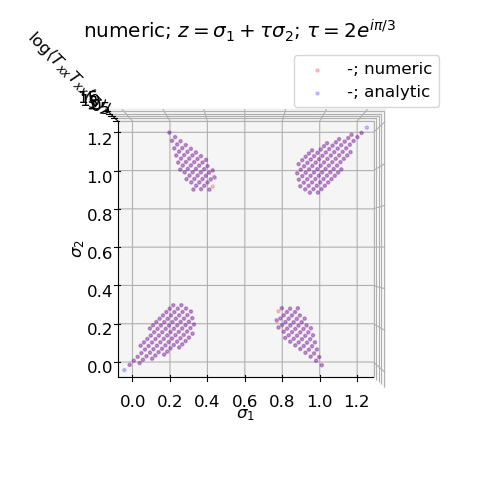

In [115]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(1.0))

#################

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter( XY.T[0], XY.T[1], np.log(numeric_scaled), 
           c='r', marker='.', label="-; numeric", alpha=0.2)

ax.scatter( XY.T[0], XY.T[1], 
           np.log( analy_mixed ), 
           c='b', marker='.', label="-; analytic", alpha=0.2)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
# plt.savefig('../TxxTxx_G.pdf',bbox_inches='tight')

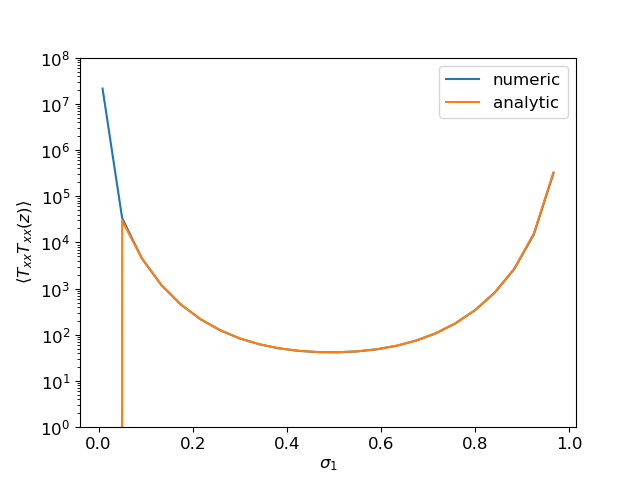

In [124]:
plt.close()
# y = mixed[Mu]
signs = [1, -1, 1, 1, -1, 1]
signs2 = [1, -1, -1, -1, -1, 1]
sign = -signs[A]*signs[B]
# sign2 = signs2[Mu]
# sign = 1

plt.plot( XY.T[0][:int(Lxeff/2)], sign*numeric_scaled[:int(Lxeff/2)], label="numeric")
plt.plot( XY.T[0][:int(Lxeff/2)], sign*analy_mixed[:int(Lxeff/2)], label="analytic")

plt.ylim(1.0,1.0e8)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

# $TT$ v2 (reserved)

In [67]:
def f_ell1(tau1, tau2):
    return np.sqrt( (1.0+tau1)**2 + tau2**2 )
def f_ell0(tau1, tau2):
    return np.sqrt( (1.0-2.0*tau1)**2 + 4.0*tau2**2 )
def f_ell2(tau1, tau2):
    return np.sqrt( (-2.0+tau1)**2 + tau2**2 )

In [68]:
tau1, tau2 = np.real(tau), np.imag(tau)

In [73]:
print( f_ell0(tau1, tau2) - Ell[0], f_ell1(tau1, tau2) - Ell[1], f_ell2(tau1, tau2) - Ell[2] )

0.13199636723549357 -0.4368293953062139 0.4505185794924136


In [74]:
def f_kappa0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell0 / (v_ell0 + v_ell1 + v_ell2)

def f_kappa1(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell1 / (v_ell0 + v_ell1 + v_ell2)

def f_kappa2(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell2 / (v_ell0 + v_ell1 + v_ell2)

In [75]:
print( f_kappa0(tau1, tau2) - kappa[0], f_kappa1(tau1, tau2) - kappa[1], f_kappa2(tau1, tau2) - kappa[2] )

0.03386552286057487 -0.19325074653673668 0.15938522367616192


In [76]:
def d1f_ell1(tau1, tau2):
    v_ell1 = f_ell1(tau1, tau2)
    return 1.0/v_ell1 * (1.0+tau1)

def d2f_ell1(tau1, tau2):
    v_ell1 = f_ell1(tau1, tau2)
    return 1.0/v_ell1 * tau2

def d1f_ell0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    return -2.0/v_ell0 * (1.0-2.0*tau1)

def d2f_ell0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    return 1.0/v_ell0 * 4.0*tau2

def d1f_ell2(tau1, tau2):
    v_ell2 = f_ell2(tau1, tau2)
    return 1.0/v_ell2 * (-2.0+tau1)

def d2f_ell2(tau1, tau2):
    v_ell2 = f_ell2(tau1, tau2)
    return 1.0/v_ell2 * tau2

In [77]:
eps = 1.0e-7
print( ( f_ell0(tau1+eps, tau2) - f_ell0(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell0(tau1, tau2) )
print( ( f_ell0(tau1, tau2+eps) - f_ell0(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell0(tau1, tau2) )

print( ( f_ell1(tau1+eps, tau2) - f_ell1(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell1(tau1, tau2) )
print( ( f_ell1(tau1, tau2+eps) - f_ell1(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell1(tau1, tau2) )

print( ( f_ell2(tau1+eps, tau2) - f_ell2(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell2(tau1, tau2) )
print( ( f_ell2(tau1, tau2+eps) - f_ell2(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell2(tau1, tau2) )

4.86446549707864e-10
-8.798455297664987e-10
8.993554789782365e-10
-1.2886676170609235e-09
-2.3863426790171616e-09
7.439152627242152e-10


In [78]:
d1f_ell0(tau1, tau2) + d1f_ell1(tau1, tau2) + d1f_ell2(tau1, tau2)

-0.9390415646168749

In [79]:
d2f_ell0(tau1, tau2) + d2f_ell1(tau1, tau2) + d2f_ell2(tau1, tau2)

2.7507276859441587

In [80]:
def d1f_kappa0(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell0 - v_ell0*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa0(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell0 - v_ell0*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d1f_kappa1(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell1 - v_ell1*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa1(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell1 - v_ell1*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d1f_kappa2(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell2 - v_ell2*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa2(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell2 - v_ell2*dsum/sum
    tmp *= 2.0/sum

    return tmp

In [81]:
eps = 1.0e-4
print( ( f_kappa0(tau1+eps, tau2) - f_kappa0(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa0(tau1, tau2) )
print( ( f_kappa0(tau1, tau2+eps) - f_kappa0(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa0(tau1, tau2) )

print( ( f_kappa1(tau1+eps, tau2) - f_kappa1(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa1(tau1, tau2) )
print( ( f_kappa1(tau1, tau2+eps) - f_kappa1(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa1(tau1, tau2) )

print( ( f_kappa2(tau1+eps, tau2) - f_kappa2(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa2(tau1, tau2) )
print( ( f_kappa2(tau1, tau2+eps) - f_kappa2(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa2(tau1, tau2) )

2.1719372689243954e-09
1.8716411753771922e-10
-1.6696780624769758e-09
-2.712977481555967e-10
-5.03369484983196e-10
8.30236990267963e-11


In [82]:
K0K0 = np.loadtxt("../data/"+description+"K0K0.dat")
K0K1 = np.loadtxt("../data/"+description+"K0K1.dat")
K0K2 = np.loadtxt("../data/"+description+"K0K2.dat")
#
K1K0 = np.loadtxt("../data/"+description+"K1K0.dat")
K1K1 = np.loadtxt("../data/"+description+"K1K1.dat")
K1K2 = np.loadtxt("../data/"+description+"K1K2.dat")
#
K2K0 = np.loadtxt("../data/"+description+"K2K0.dat")
K2K1 = np.loadtxt("../data/"+description+"K2K1.dat")
K2K2 = np.loadtxt("../data/"+description+"K2K2.dat")

##

K0E = np.loadtxt("../data/"+description+"K0E.dat")
K1E = np.loadtxt("../data/"+description+"K1E.dat")
K2E = np.loadtxt("../data/"+description+"K2E.dat")
#
K0E0 = np.loadtxt("../data/"+description+"K0E0.dat")
K1E0 = np.loadtxt("../data/"+description+"K1E0.dat")
K2E0 = np.loadtxt("../data/"+description+"K2E0.dat")
#
K0E1 = np.loadtxt("../data/"+description+"K0E1.dat")
K1E1 = np.loadtxt("../data/"+description+"K1E1.dat")
K2E1 = np.loadtxt("../data/"+description+"K2E1.dat")
#
K0E2 = np.loadtxt("../data/"+description+"K0E2.dat")
K1E2 = np.loadtxt("../data/"+description+"K1E2.dat")
K2E2 = np.loadtxt("../data/"+description+"K2E2.dat")

##
EK0 = np.loadtxt("../data/"+description+"EK0.dat")
EK1 = np.loadtxt("../data/"+description+"EK1.dat")
EK2 = np.loadtxt("../data/"+description+"EK2.dat")
#
E0K0 = np.loadtxt("../data/"+description+"E0K0.dat")
E0K1 = np.loadtxt("../data/"+description+"E0K1.dat")
E0K2 = np.loadtxt("../data/"+description+"E0K2.dat")
#
E1K0 = np.loadtxt("../data/"+description+"E1K0.dat")
E1K1 = np.loadtxt("../data/"+description+"E1K1.dat")
E1K2 = np.loadtxt("../data/"+description+"E1K2.dat")
#
E2K0 = np.loadtxt("../data/"+description+"E2K0.dat")
E2K1 = np.loadtxt("../data/"+description+"E2K1.dat")
E2K2 = np.loadtxt("../data/"+description+"E2K2.dat")

##

E0E = np.loadtxt("../data/"+description+"E0E.dat")
E1E = np.loadtxt("../data/"+description+"E1E.dat")
E2E = np.loadtxt("../data/"+description+"E2E.dat")
#
EE0 = np.loadtxt("../data/"+description+"EE0.dat")
EE1 = np.loadtxt("../data/"+description+"EE1.dat")
EE2 = np.loadtxt("../data/"+description+"EE2.dat")
#
EE = np.loadtxt("../data/"+description+"EE.dat")

##

E0E0 = np.loadtxt("../data/"+description+"E0E0.dat")
E0E1 = np.loadtxt("../data/"+description+"E0E1.dat")
E0E2 = np.loadtxt("../data/"+description+"E0E2.dat")
#
E1E0 = np.loadtxt("../data/"+description+"E1E0.dat")
E1E1 = np.loadtxt("../data/"+description+"E1E1.dat")
E1E2 = np.loadtxt("../data/"+description+"E1E2.dat")
#
E2E0 = np.loadtxt("../data/"+description+"E2E0.dat")
E2E1 = np.loadtxt("../data/"+description+"E2E1.dat")
E2E2 = np.loadtxt("../data/"+description+"E2E2.dat")

In [83]:
# TTconn_analytic = np.array([ [elem[2], elem[3], TTconn(elem[2]+1.0j*elem[3] - src_cplx) ] for elem in pts] )
TTconn_analytic = np.array([ [elem[2], elem[3], TTconn(elem[2]+1.0j*elem[3] - src_cplx) ] for elem in pts] )

In [84]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

In [85]:
# def mixing(x, A_, theta_ ):
#     return A_*np.cos(theta_)*x[0] - A_*np.sin(theta_)*x[1]
def mixing(x, A_, theta_ ):
    return A_*np.cos(theta_)*x[0] - A_*np.sin(theta_)*x[1]
# def mixingsq(x, A_, theta_ ):
#     return A_*np.cos(theta_)**2 *x[0] + A_*np.sin(theta_)**2 *x[1]

In [86]:
Tn0Tn0 = K0K0 - 0.5*(K0E+K0E0) - 0.5*(EK0+E0K0) + 0.25*(EE+EE0+E0E+E0E0)
Tn0Tn1 = K0K1 - 0.5*(K0E+K0E1) - 0.5*(EK1+E0K1) + 0.25*(EE+EE1+E0E+E0E1)
Tn0Tn2 = K0K2 - 0.5*(K0E+K0E2) - 0.5*(EK2+E0K2) + 0.25*(EE+EE2+E0E+E0E2)

Tn1Tn0 = K1K0 - 0.5*(K1E+K1E0) - 0.5*(EK0+E1K0) + 0.25*(EE+EE0+E1E+E1E0)
Tn1Tn1 = K1K1 - 0.5*(K1E+K1E1) - 0.5*(EK1+E1K1) + 0.25*(EE+EE1+E1E+E1E1)
Tn1Tn2 = K1K2 - 0.5*(K1E+K1E2) - 0.5*(EK2+E1K2) + 0.25*(EE+EE2+E1E+E1E2)

Tn2Tn0 = K2K0 - 0.5*(K2E+K2E0) - 0.5*(EK0+E2K0) + 0.25*(EE+EE0+E2E+E2E0)
Tn2Tn1 = K2K1 - 0.5*(K2E+K2E1) - 0.5*(EK1+E2K1) + 0.25*(EE+EE1+E2E+E2E1)
Tn2Tn2 = K2K2 - 0.5*(K2E+K2E2) - 0.5*(EK2+E2K2) + 0.25*(EE+EE2+E2E+E2E2)

In [87]:
s2A = np.sin(2.0*alA)
s2B = np.sin(2.0*alB)
s2C = np.sin(2.0*alC)

c2A = np.cos(2.0*alA)
c2B = np.cos(2.0*alB)
c2C = np.cos(2.0*alC)

In [88]:
phi =  + np.arctan(pts[1][3]/pts[1][2])
phi

0.10676304898561612

In [89]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

In [118]:
ZA = 1.0/(alat)
# ZB = 1.0/(alat * Ellstar[0] * 2.0*np.cos(alB) )
ZB = 1.0/(alat * np.cos(alC)/np.cos(2.0*alB) ) # 0.615
ZC = 1.0/(alat)

# angles = [
#     2.0*alA - 2.0*np.arctan(pts[1][3]/pts[1][2]), 
#     2.0*alB, # - 2.0*np.arctan(pts[1][3]/pts[1][2]), 
#     2.0*alC, # - 2.0*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alB+alC) - 2.0*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alC+alA) - 2.5*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alA+alB) - 2.0*np.arctan(pts[1][3]/pts[1][2]),
# ]

# angles = [
#     np.pi -alA + 2.0*np.arctan(pts[1][3]/pts[1][2]), 
#     np.pi -alB + 2.0*np.arctan(pts[1][3]/pts[1][2]), 
#     np.pi -alC + 2.0*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alB+alC) - 2.0*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alC+alA) - 2.5*np.arctan(pts[1][3]/pts[1][2]),
#     0.5*(alA+alB) - 2.0*np.arctan(pts[1][3]/pts[1][2]),
# ]

angles = [
    alA - 2.0*np.arctan(pts[1][3]/pts[1][2]), 
    alB - 2.2*np.arctan(pts[1][3]/pts[1][2]), 
    alC - 2.3*np.arctan(pts[1][3]/pts[1][2]),
    0.5*(alB+alC) - 2.15*np.arctan(pts[1][3]/pts[1][2]),
    0.5*(alC+alA) - 2.15*np.arctan(pts[1][3]/pts[1][2]),
    0.5*(alA+alB) - 2.0*np.arctan(pts[1][3]/pts[1][2]),
]


# angles2 = [
#     alA, 
#     alB, # - 2.0*np.arctan(pts[1][3]/pts[1][2]), 
#     alC, # - 2.0*np.arctan(pts[1][3]/pts[1][2])
# ]

TnATnA = (2.0*np.pi)**2 * ZA**2 * 1.0/r**4 * np.array(Tn0Tn0)
TnBTnB = (2.0*np.pi)**2 * ZB**2 * 1.0/r**4 * np.array(Tn1Tn1)
TnCTnC = (2.0*np.pi)**2 * ZC**2 * 1.0/r**4 * np.array(Tn2Tn2)

TnBTnC = (2.0*np.pi)**2 * ZB*ZC * 1.0/r**4 * np.array(Tn1Tn2)
TnCTnA = (2.0*np.pi)**2 * ZC*ZA * 1.0/r**4 * np.array(Tn2Tn0)
TnATnB = (2.0*np.pi)**2 * ZA*ZB * 1.0/r**4 * np.array(Tn0Tn1)

TTs = [TnATnA.T[2], TnBTnB.T[2], TnCTnC.T[2], TnBTnC.T[2], TnCTnA.T[2], TnATnB.T[2] ]

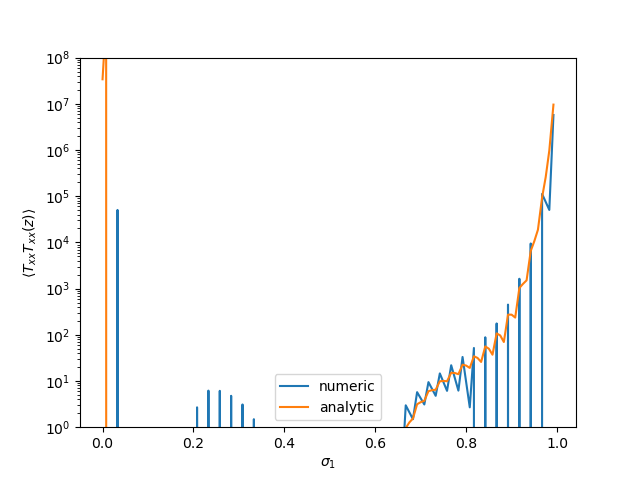

In [119]:
plt.close()
fact = 1.0 # 14.0
# rrr = 1.0/np.cos( 2.0*np.arctan(pts[1][3]/pts[1][2]) )**12

Mu = 1
y=mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], -1.0, angles[Mu] )
# y=mixingsq( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angles2[Mu] )
signs = [1, 1, 1, -1, -1, -1]
signs2 = [1, 1, 1, -1, 1, 1]
sign = signs[Mu]
sign2 = signs2[Mu]

plt.plot( xlat[:int(2*Lx/3)], sign2*TTs[Mu][:int(2*Lx/3)], label="numeric")
# plt.plot( xlat[:int(2*Lx/3)], -TTs[Mu][:int(2*Lx/3)], label="numeric")
# plt.plot( TTconn_analytic.T[0][:int(Lx)], rat*0.5*np.real(TTconn_analytic.T[2][:int(Lx)]), label="analytic")
plt.plot( TTconn_analytic.T[0][:int(Lx)], 
          sign*2.0*y[:int(Lx)],
          label="analytic")
# plt.plot( TTconn_analytic.T[0][:int(Lx)], 
#           -fact*2.0*y[:int(Lx)],
#           label="analytic")

plt.ylim(1.0,1.0e8)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

/tmp/ipykernel_16035/2514158480.py:12: RuntimeWarning: invalid value encountered in log
  ax.scatter( xlat, ylat, np.log(TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
/tmp/ipykernel_16035/2514158480.py:14: RuntimeWarning: invalid value encountered in log
  np.log( mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], -1.0, angles[Mu] ) ),


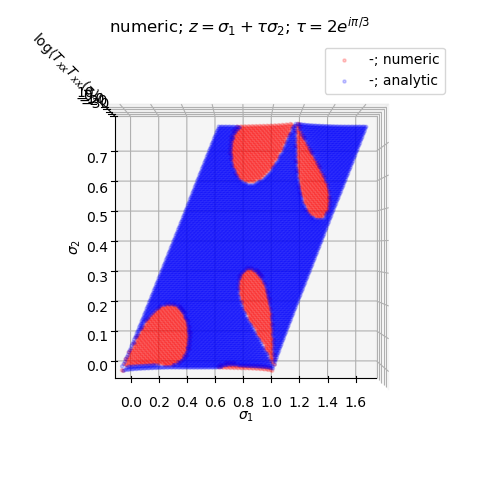

In [120]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(1.0))

Mu = 4

#################

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter( xlat[1::2], ylat[1::2], np.log(-TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter( xlat, ylat, np.log(TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
           np.log( mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], -1.0, angles[Mu] ) ), 
           c='b', marker='.', label="-; analytic", alpha=0.2)
# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
#            np.log( -mixingsq( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angles2[Mu] ) ), 
#            c='b', marker='.', label="-; analytic", alpha=0.2)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

#################

fig.tight_layout()
# plt.savefig('../TxxTxx_G.pdf',bbox_inches='tight')

In [94]:
d1k0 = d1f_kappa0(tau1, tau2)
d1k1 = d1f_kappa1(tau1, tau2)
d1k2 = d1f_kappa2(tau1, tau2)

d2k0 = d2f_kappa0(tau1, tau2)
d2k1 = d2f_kappa1(tau1, tau2)
d2k2 = d2f_kappa2(tau1, tau2)

In [95]:
matT = np.array([
    [Tn0Tn0,Tn0Tn1,Tn0Tn2],
    [Tn1Tn0,Tn1Tn1,Tn1Tn2],
    [Tn2Tn0,Tn2Tn1,Tn2Tn2]
])

In [96]:
d1k0+d1k1+d1k2, d2k0+d2k1+d2k2

(5.551115123125783e-17, 5.551115123125783e-17)

In [97]:
matd1 = np.array([
    [d1k0*d1k0, d1k0*d1k1, d1k0*d1k2],
    [d1k1*d1k0, d1k1*d1k1, d1k1*d1k2],
    [d1k2*d1k0, d1k2*d1k1, d1k2*d1k2]
])

In [98]:
matd1

array([[ 0.04085754, -0.09722012,  0.05636258],
       [-0.09722012,  0.23133433, -0.1341142 ],
       [ 0.05636258, -0.1341142 ,  0.07775162]])

In [99]:
TnxyTnxy = (Ntri*np.pi)**2 * np.sum( np.array([[ matT[i][j]*matd1[i][j] for i in {0,1,2}] for j in {0,1,2} ]), axis=(0,1) )

/tmp/ipykernel_12245/900430561.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter( xlat, ylat, np.log( TnxyTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
/tmp/ipykernel_12245/900430561.py:12: RuntimeWarning: invalid value encountered in log
  np.log( -mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, -np.pi/2.0) ),
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


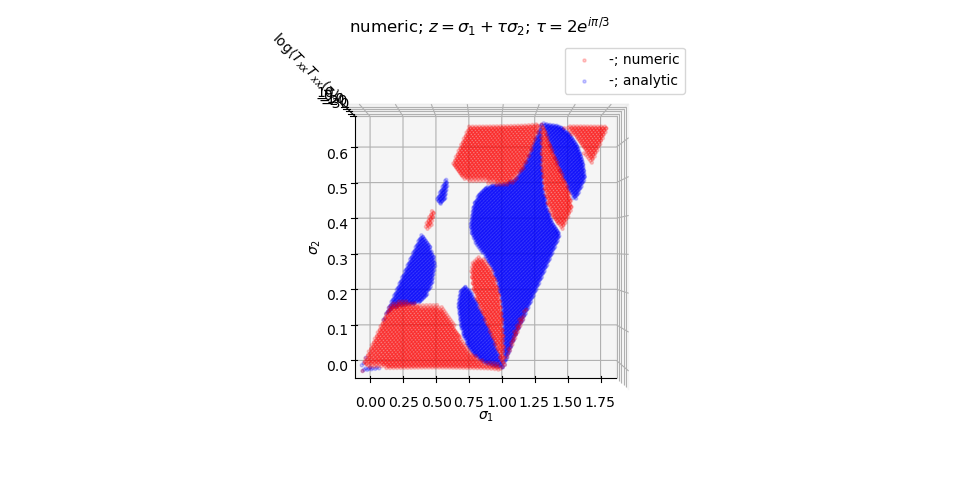

In [103]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter( xlat[1::2], ylat[1::2], np.log(-TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter( xlat, ylat, np.log( TnxyTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
           np.log( -mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, -np.pi/2.0) ), 
           c='b', marker='.', label="-; analytic", alpha=0.2)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

#################

fig.tight_layout()
plt.savefig('../TxxTxx_G'+str(Lx)+'.pdf',bbox_inches='tight')

In [107]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# angle = alC + np.pi + 2.0*np.arccos(e[0][0]) # 0.24 * np.pi

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=-90)

# # ax.scatter( xlat[::], ylat[::], np.log(-TnCTnC.T[2]), c='b', marker='o', label="-", alpha=0.3)
# ax.scatter( xlat[1::2], ylat[1::2], np.log(TnCTnC.T[2])[::], c='r', marker='.', label="+", alpha=0.3)

# ax.legend()
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("${\\rm log} \\langle T_{2}T_{2}(z) \\rangle$")
# ax.set_title("numeric; $\\tau = $"+'{:.3f}'.format(tau)+"; L="+str(Lx))



# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=-90)

# # ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
# #            np.log( -mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle ) ), 
# #            c='b', marker='o', label="-", alpha=0.3)
# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
#            np.log( mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle ) ), 
#            c='r', marker='.', label="+", alpha=0.3)


# ax.legend()
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("${\\rm log} \\langle T_{2}T_{2}(z) \\rangle$")
# ax.set_title("exact; $\\tau = $"+'{:.3f}'.format(tau)+"; L="+str(Lx) )
# ax.set_zlim( 0, 20 )

# #################

# #################

# fig.tight_layout()
# # plt.savefig('../T2T2.pdf',bbox_inches='tight')

In [136]:
# plt.close()

# angle = alA # 0.24 * np.pi
# mix = mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle )

# plt.plot( K0K0.T[0][:int(Lx/3)]/Lx, TnATnA.T[2][:int(Lx/3)], label="numeric")
# # plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.real(TTconn_analytic.T[2][:Lx]), label="analytic")
# plt.plot( TTconn_analytic.T[0][:int(Lx)], 
#          0.3*mix[:int(Lx)],
#          label="analytic")

# plt.ylim(1.0,1.0e8)
# plt.legend()

# plt.xlabel("$\\sigma_1$")
# plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

# plt.yscale("log")
# # plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

# $\langle T_\nu \rangle$ v2

$$
\langle T \rangle_\nu
=
{1\over 2}
\langle :\hspace{-0.2em}\eta \partial \eta \hspace{-0.2em}: \rangle_\nu
=
-(1/4)e_{\nu-1}
$$

In [196]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])
alphaM = [alA, alB, alC]

def ArcTan( x, y ):
    tmp = np.arctan( y/x )
    if x<0:
        tmp += np.pi
    return tmp

tildeAlA = ArcTan( tilde_ell[0][0], tilde_ell[0][1] )
tildeAlB = ArcTan( tilde_ell[1][0], tilde_ell[1][1] )
tildeAlC = ArcTan( tilde_ell[2][0], tilde_ell[2][1] )

tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

In [197]:
TildeEll = np.array([ 
    np.linalg.norm(tilde_ell[0]),
    np.linalg.norm(tilde_ell[1]), 
    np.linalg.norm(tilde_ell[2]) 
])

def mixing(x, theta_ ):
    return np.cos(theta_)*x[0] - np.sin(theta_)*x[1]

In [198]:
def square( x, c0, c2 ):
    return c0 + c2*x**2

In [203]:
nu = 4
eps_vev_=[]

for LL in np.arange(72, 240, 12):
# for LL in np.arange(120, 240, 12):
    description="Lx"+str(LL)+"Ly"+str(LL)+"nu"+str(nu)+"tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)+str(is_orthogonal)
    eps5 = np.loadtxt("../data/"+description+"eps_vev.dat")
    eps_vev_.append([LL,eps5[0]])

if nu==2:
    eps_vev2 = np.array(eps_vev_)
if nu==3:
    eps_vev3 = np.array(eps_vev_)
if nu==4:
    eps_vev4 = np.array(eps_vev_)

In [204]:
x, y = 1.0/eps_vev2.T[0], eps_vev2.T[1]
eps_fit2 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )
x, y = 1.0/eps_vev2.T[0], eps_vev3.T[1]
eps_fit3 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )
x, y = 1.0/eps_vev2.T[0], eps_vev4.T[1]
eps_fit4 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

In [205]:
eps_fits = np.array( [eps_fit2[0][0], eps_fit3[0][0], eps_fit4[0][0]] )

In [206]:
ceps = np.mean( eps_fits )

In [213]:
ceps_err = np.sqrt( np.var( eps_fits )/2 )

In [214]:
eps_fit2

(array([-1.51210538, -0.81961175]),
 array([[ 9.33575348e-18, -9.07559387e-14],
        [-9.07559387e-14,  1.40681113e-09]]))

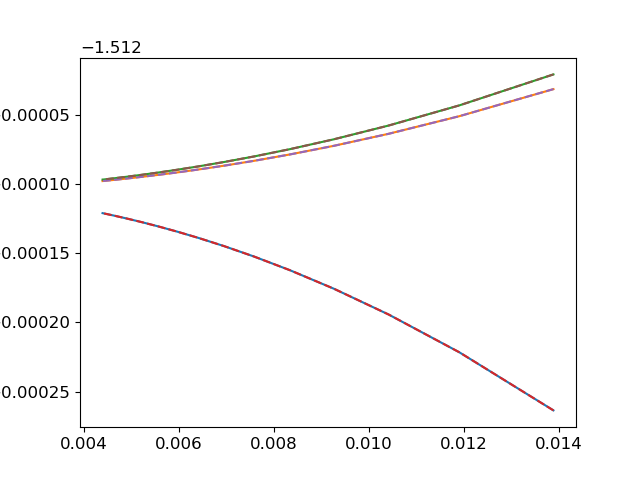

In [215]:
plt.close()
plt.plot(1.0/eps_vev2.T[0], eps_vev2.T[1])
plt.plot(1.0/eps_vev3.T[0], eps_vev3.T[1])
plt.plot(1.0/eps_vev4.T[0], eps_vev4.T[1])

x = 1.0/eps_vev2.T[0]
y = square( x, eps_fit2[0][0], eps_fit2[0][1] )
plt.plot( x, y, ls="dashed" )

x = 1.0/eps_vev3.T[0]
y = square( x, eps_fit3[0][0], eps_fit3[0][1] )
plt.plot( x, y, ls="dashed" )

x = 1.0/eps_vev4.T[0]
y = square( x, eps_fit4[0][0], eps_fit4[0][1] )
plt.plot( x, y, ls="dashed" )

In [216]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (eps_vev2.T[1] - ceps)

array([-0.02281248, -0.02281642, -0.02281911, -0.02282109, -0.02282264,
       -0.02282392, -0.02282504, -0.02282605, -0.022827  , -0.0228279 ,
       -0.02282879, -0.02282967, -0.02283055, -0.02283145])

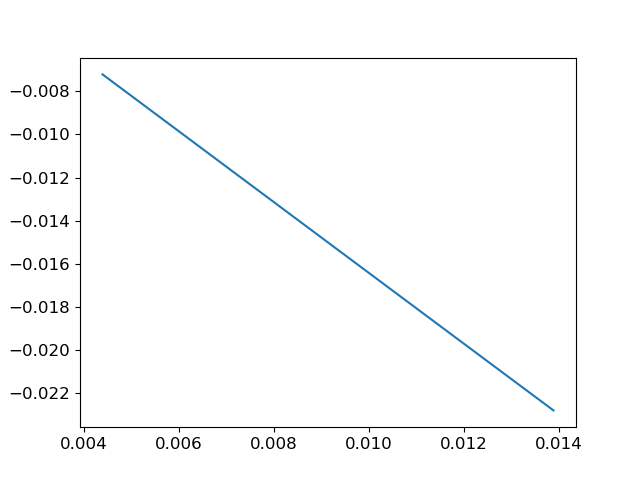

In [217]:
plt.close()
plt.plot( 1.0/eps_vev2.T[0], (eps_vev2.T[0]/72) * (2.0*np.pi)/r**2 * (eps_vev2.T[1] - ceps) )

In [220]:
nu = 2

t_vevA_=[]
t_vevB_=[]
t_vevC_=[]

for LL in np.arange(72, 240, 12):
    description="Lx"+str(LL)+"Ly"+str(LL)+"nu"+str(nu)+"tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)+str(is_orthogonal)
    tA = np.loadtxt("../data/"+description+"t_vev_v2_0.dat")
    tB = np.loadtxt("../data/"+description+"t_vev_v2_1.dat")
    tC = np.loadtxt("../data/"+description+"t_vev_v2_2.dat")
    t_vevA_.append([LL, tA[0]])
    t_vevB_.append([LL, tB[0]])
    t_vevC_.append([LL, tC[0]])

if nu==2:
    t_vevA_2 = np.array(t_vevA_)
    t_vevB_2 = np.array(t_vevB_)
    t_vevC_2 = np.array(t_vevC_)

if nu==3:
    t_vevA_3 = np.array(t_vevA_)
    t_vevB_3 = np.array(t_vevB_)
    t_vevC_3 = np.array(t_vevC_)

if nu==4:
    t_vevA_4 = np.array(t_vevA_)
    t_vevB_4 = np.array(t_vevB_)
    t_vevC_4 = np.array(t_vevC_)

In [221]:
x, y = 1.0/eps_vev2.T[0], t_vevA_2.T[1]
t_vevA_fit2 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/eps_vev2.T[0], t_vevB_2.T[1]
t_vevB_fit2 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/eps_vev2.T[0], t_vevC_2.T[1]
t_vevC_fit2 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

In [222]:
x, y = 1.0/t_vevA_3.T[0], t_vevA_3.T[1]
t_vevA_fit3 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/t_vevA_3.T[0], t_vevB_3.T[1]
t_vevB_fit3 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/t_vevA_3.T[0], t_vevC_3.T[1]
t_vevC_fit3 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

In [223]:
x, y = 1.0/eps_vev2.T[0], t_vevA_4.T[1]
t_vevA_fit4 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/eps_vev2.T[0], t_vevB_4.T[1]
t_vevB_fit4 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

x, y = 1.0/eps_vev2.T[0], t_vevC_4.T[1]
t_vevC_fit4 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

In [224]:
tA_fits = np.array([ t_vevA_fit2[0][0], t_vevA_fit3[0][0], t_vevA_fit4[0][0] ])
tB_fits = np.array([ t_vevB_fit2[0][0], t_vevB_fit3[0][0], t_vevB_fit4[0][0] ])
tC_fits = np.array([ t_vevC_fit2[0][0], t_vevC_fit3[0][0], t_vevC_fit4[0][0] ])

In [229]:
c_tA = np.mean(tA_fits)
c_tB = np.mean(tB_fits)
c_tC = np.mean(tC_fits)

c_tA_err = np.sqrt( np.var(tA_fits)/2 )
c_tB_err = np.sqrt( np.var(tB_fits)/2 )
c_tC_err = np.sqrt( np.var(tC_fits)/2 )

In [230]:
c = -0.5

In [231]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevA_3.T[1] - t_vevA_fit3[0][0] + c*(eps_vev3.T[1] - eps_fit3[0][0]) ) / (TildeEll * alat)[0]

array([1.02274369, 1.02310675, 1.02329133, 1.02336551, 1.02336517,
       1.0233107 , 1.02321438, 1.02308394, 1.02292449, 1.02273945,
       1.02253125, 1.02230159, 1.02205175, 1.02178265])

In [232]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevB_3.T[1] - t_vevB_fit3[0][0] + c*(eps_vev3.T[1] - eps_fit3[0][0]) ) / (TildeEll * alat)[1]

array([-0.71564891, -0.71593382, -0.71607868, -0.71613689, -0.71613663,
       -0.71609389, -0.7160183 , -0.71591594, -0.71579081, -0.7156456 ,
       -0.7154822 , -0.71530197, -0.7151059 , -0.71489471])

In [233]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevC_3.T[1] - t_vevC_fit3[0][0] + c*(eps_vev3.T[1] - eps_fit3[0][0]) ) / (TildeEll * alat)[2]

array([-0.14931237, -0.14933227, -0.14934238, -0.14934644, -0.14934642,
       -0.14934344, -0.14933816, -0.14933102, -0.14932229, -0.14931216,
       -0.14930077, -0.1492882 , -0.14927452, -0.14925979])

In [234]:
div_tA

0.2308800073288377

In [180]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevA_2.T[1] - div_tA + c*(eps_vev2.T[1] - ceps) ) / (TildeEll * alat)[0]

array([-3.10004792, -3.10017384, -3.10027346, -3.10035488, -3.10042341,
       -3.10048264, -3.10053509, -3.10058256, -3.10062635, -3.10066745])

In [181]:
(eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevA_3.T[1] - div_tA + c*(eps_vev3.T[1] - ceps) ) / (TildeEll * alat)[0]

array([1.02409184, 1.02418998, 1.02426079, 1.02431203, 1.02434877,
       1.02437447, 1.02439154, 1.02440169, 1.02440618, 1.02440595])

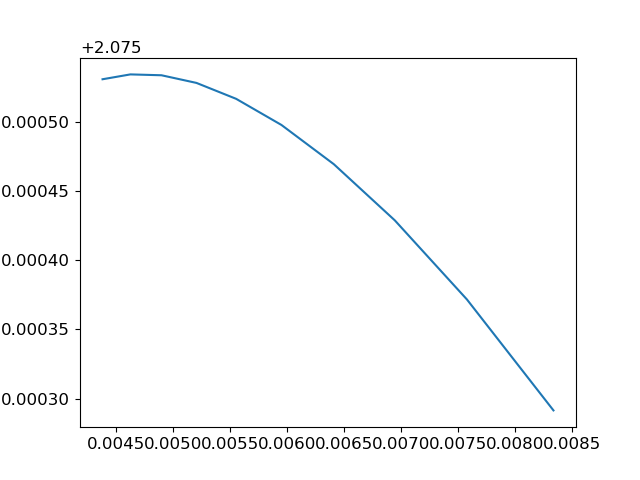

In [193]:
xx = 1.0/eps_vev2.T[0]
yy = (eps_vev2.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_vevA_4.T[1] - div_tA + c*(eps_vev4.T[1] - ceps) ) / (TildeEll * alat)[0]

plt.close()
plt.plot(xx, yy)

In [184]:
Tvev = -0.25*e2
mixing( [np.real(Tvev), np.imag(Tvev)], angle )

-0.07471186296782625

In [188]:
A = 0

angle = alphaM[A]+tildealphaM[A]

Tvev = -0.25*e1
2.0 * mixing( [np.real(Tvev), np.imag(Tvev)], angle )
# analy_mixed = 2.0 * mixing( [np.real(tt_analy_), np.imag(tt_analy_)], angle )

-3.100652909619329

In [189]:
Tvev = -0.25*e2
2.0 * mixing( [np.real(Tvev), np.imag(Tvev)], angle )

1.024778403226181

In [190]:
Tvev = -0.25*e3
2.0 * mixing( [np.real(Tvev), np.imag(Tvev)], angle )

2.0758745063931476

In [ ]:
mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, alA )

In [136]:
nu = 3

# Lx = 6
# Ly = 12

In [137]:
# d1k0 = d1f_kappa0(tau1, tau2)
# d1k1 = d1f_kappa1(tau1, tau2)
# d1k2 = d1f_kappa2(tau1, tau2)

# d2k0 = d2f_kappa0(tau1, tau2)
# d2k1 = d2f_kappa1(tau1, tau2)
# d2k2 = d2f_kappa2(tau1, tau2)

In [139]:
t0 = np.loadtxt("../data/"+description+"t_vev_v2_0.dat")
t1 = np.loadtxt("../data/"+description+"t_vev_v2_1.dat")
t2 = np.loadtxt("../data/"+description+"t_vev_v2_2.dat")
t0, t1, t2
# eps_vev = np.loadtxt("../data/"+description+"eps_vev.dat")

(array([ 2.31005534e-01, -2.33320308e-16,  0.00000000e+00]),
 array([ 2.64260717e-01, -5.81132364e-17,  1.00000000e+00]),
 array([2.42737530e-01, 1.47451495e-16, 2.00000000e+00]))

In [91]:
Tvev = -0.25*e2
Tvev

(-0.41369520099725865+0j)

In [92]:
0.5*(t0[0]-0.25) / (alat * Ellstar[0]) * (2.0*np.pi) / r**2

-0.41402944961485727

In [93]:
0.5*(t1[0]-0.25) / (alat * Ellstar[1]) * (2.0*np.pi) / r**2

0.207014724814678

In [94]:
0.5*(t2[0]-0.25) / (alat * Ellstar[1]) * (2.0*np.pi) / r**2

0.20701472481081165

In [97]:
mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, alA )

0.41369520099725865

In [38]:
t_mu0_M0s_=[]
t_mu0_M1s_=[]
t_mu0_M2s_=[]

t_mu1_M0s_=[]
t_mu1_M1s_=[]
t_mu1_M2s_=[]

for LL in np.arange(72, 200, 12):
    t_mu0_M0 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu0_M0.dat" )
    t_mu0_M1 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu0_M1.dat" )
    t_mu0_M2 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu0_M2.dat" )

    t_mu1_M0 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu1_M0.dat" )
    t_mu1_M1 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu1_M1.dat" )
    t_mu1_M2 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_mu1_M2.dat" )

    t_mu0_M0s_.append([LL, t_mu0_M0[0]])
    t_mu0_M1s_.append([LL, t_mu0_M1[0]])
    t_mu0_M2s_.append([LL, t_mu0_M2[0]])

    t_mu1_M0s_.append([LL, t_mu1_M0[0]])
    t_mu1_M1s_.append([LL, t_mu1_M1[0]])
    t_mu1_M2s_.append([LL, t_mu1_M2[0]])

t_mu0_M0s=np.array(t_mu0_M0s_)
t_mu0_M1s=np.array(t_mu0_M1s_)
t_mu0_M2s=np.array(t_mu0_M2s_)

t_mu1_M0s=np.array(t_mu1_M0s_)
t_mu1_M1s=np.array(t_mu1_M1s_)
t_mu1_M2s=np.array(t_mu1_M2s_)

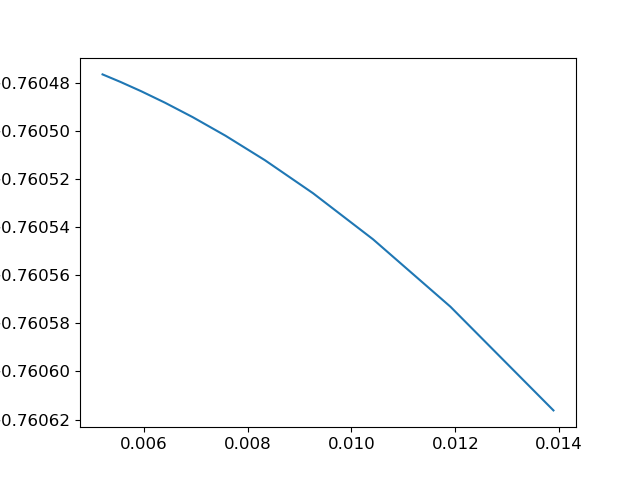

In [39]:
plt.close()
plt.plot( 1.0/t_mu0_M0s.T[0], t_mu0_M0s.T[1] )

In [41]:
x, y = 1.0/t_mu0_M0s.T[0], t_mu0_M0s.T[1]
t_mu0_M0_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

x, y = 1.0/t_mu0_M1s.T[0], t_mu0_M1s.T[1]
t_mu0_M1_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

x, y = 1.0/t_mu0_M2s.T[0], t_mu0_M2s.T[1]
t_mu0_M2_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

x, y = 1.0/t_mu1_M0s.T[0], t_mu1_M0s.T[1]
t_mu1_M0_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

x, y = 1.0/t_mu1_M1s.T[0], t_mu1_M1s.T[1]
t_mu1_M1_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

x, y = 1.0/t_mu1_M2s.T[0], t_mu1_M2s.T[1]
t_mu1_M2_fit3 = sp.optimize.curve_fit(square, x, y, p0=[1.0, 0.39] )

In [60]:
0.5 * (t_mu0_M0s.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_mu0_M0s.T[1] - t_mu0_M0_fit3[0][0]) / (TildeEll * alat)[0]

array([-0.9373847 , -0.93737602, -0.93737216, -0.93737124, -0.93737232,
       -0.93737487, -0.93737856, -0.93738321, -0.93738869, -0.93739491,
       -0.93740181])

In [61]:
0.5 * (t_mu0_M0s.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_mu0_M1s.T[1] - t_mu0_M1_fit3[0][0]) / (TildeEll * alat)[1]

array([0.04654986, 0.0469871 , 0.04718625, 0.04723599, 0.0471831 ,
       0.04705415, 0.04686512, 0.04662611, 0.04634374, 0.04602252,
       0.04566558])

In [62]:
0.5 * (t_mu0_M0s.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_mu0_M2s.T[1] - t_mu0_M2_fit3[0][0]) / (TildeEll * alat)[2]

array([0.78692901, 0.78701933, 0.78706049, 0.78707078, 0.78705986,
       0.78703322, 0.78699416, 0.78694476, 0.7868864 , 0.78682   ,
       0.78674622])

In [63]:
A = 0
angle = tildealphaM[A]
Tvev = -0.25*e2
2.0*mixing( [np.real(Tvev), np.imag(Tvev)], angle )

-0.9373321192441507

In [64]:
A = 1
angle = tildealphaM[A]
Tvev = -0.25*e2
2.0*mixing( [np.real(Tvev), np.imag(Tvev)], angle )

0.04930123908899009

In [65]:
A = 2
angle = tildealphaM[A]
Tvev = -0.25*e2
2.0*mixing( [np.real(Tvev), np.imag(Tvev)], angle )

0.7874978948484677

In [72]:
t_M0_N0s_=[]
t_M1_N1s_=[]
t_M2_N2s_=[]

for LL in np.arange(192, 240+1, 12):
    t_M0_N0 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_M0_N0.dat" )
    t_M1_N1 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_M1_N1.dat" )
    t_M2_N2 = np.loadtxt( "../data/Lx"+str(LL)+"Ly"+str(LL)+"nu3tautil0.208378_1.181769Falset_vev_M2_N2.dat" )

    t_M0_N0s_.append([LL, t_M0_N0[0]])
    t_M1_N1s_.append([LL, t_M1_N1[0]])
    t_M2_N2s_.append([LL, t_M2_N2[0]])

t_M0_N0s=np.array(t_M0_N0s_)
t_M1_N1s=np.array(t_M1_N1s_)
t_M2_N2s=np.array(t_M2_N2s_)

In [76]:
x, y = 1.0/t_M0_N0s.T[0], t_M0_N0s.T[1]
M0N0_fit3 = sp.optimize.curve_fit(square, x, y, p0=[2.0, 0.39] )

In [82]:
0.5 * (t_M0_N0s.T[0]/72)**2 * (2.0*np.pi)/r**2 * (t_M0_N0s.T[1] - M0N0_fit3[0][0]) / (TildeEll * alat)[0]

array([1.02475495, 1.02475537, 1.02475545, 1.02475525, 1.02475481])

In [131]:
A = 2
angle = alphaM[A] + tildealphaM[A]
Tvev = -0.25*e2
2.0*mixing( [np.real(Tvev), np.imag(Tvev)], angle )

-0.1494237259356525

In [139]:
0.5*(t0[0]-t2[0]) / (alat) * (2.0*np.pi) / r**2

-1.7398556492169288e-11

In [166]:
Ellstar[0]

1.1140546750426543

In [152]:
0.5*(t0[0]-t2[0]) / (alat*Ellstar[0]) * (2.0*np.pi) / r**2

-1.5984715791004696

In [ ]:
0.5*(t0[0]-t2[0]) / (alat*Ellstar[0]) * (2.0*np.pi) / r**2

In [153]:
mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, 2.0*angles[0]-angles[2] ) - mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, 2.0*angles[2]-angles[0] )

0.29901119864867465

In [162]:
- 2.0*np.arctan(pts[1][3]/pts[1][2])

-0.21352609797123223

In [163]:
rot = 0.9
rot = 2.0*np.arctan(pts[1][3]/pts[1][2])
mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, angles[0]-rot ) - mixing( [np.real(Tvev), np.imag(Tvev)], 1.0, angles[2]-rot )

1.1172550279859141

In [141]:
1.08*np.sin(np.angle(tau))

1.0617136712154829

In [123]:
t0[0] / Ellstar[0]

0.22752248086867496

In [124]:
ZB / ZA

-1.307717207157573

In [125]:
t1[0]

0.2391204910567286

In [327]:
0.5*(t0[0]-0.25) / (alat) * (2.0*np.pi) / r**2

41.12844838848637

In [200]:
0.5*(t1[0]-0.25) / (alat * Ellstar[1]) * (2.0*np.pi) / r**2

-2953.019215748144

In [328]:
0.5*(t2[0]-0.25) / (alat) * (2.0*np.pi) / r**2

44.57920025978064

In [202]:
(t0[0]-0.2375) / (alat * Ellstar[0] * 2.0*np.cos(2.0*alC) )

-1.201101948705363

In [203]:
(t1[0]-0.266405) / (alat * Ellstar[1] * 0.85)

-35.478343466531314

In [204]:
(t2[0]-0.2375) / (alat * Ellstar[0] * 2.0*np.cos(2.0*alC) )

-1.2157104205092955

In [205]:
etaetabar[:20].T[2]

array([ 5.64255438e+01+9.54016526e-15j,  9.16408369e+00-1.84996555e+01j,
       -5.23338889e+00+5.53410883e-15j, -1.25061206e+00+2.27763928e-01j,
       -1.05753577e+00+5.88353159e-15j, -4.93053537e-01+7.40876079e-02j,
       -4.34093925e-01+5.53539389e-15j, -2.57705147e-01+3.06996916e-02j,
       -2.33934421e-01+4.61878429e-15j, -1.57186479e-01+1.54003263e-02j,
       -1.45485276e-01+4.09601988e-15j, -1.05335930e-01+8.75015425e-03j,
       -9.88126958e-02+3.39892115e-15j, -7.51578002e-02+5.41799932e-03j,
       -7.12144532e-02+2.72846140e-15j, -5.60491039e-02+3.57235641e-03j,
       -5.35326197e-02+2.07046757e-15j, -4.31611092e-02+2.47259461e-03j,
       -4.14953479e-02+1.54686351e-15j, -3.40199159e-02+1.78086953e-03j])

In [206]:
xixi00.T[2]

array([ 1.74446665e-01,  2.83319172e-02, -1.61796799e-02, ...,
       -1.00183418e-05, -9.78432924e-06, -3.90181767e-06])

In [207]:
np.cos(angle[0])np.real(Tvev)

SyntaxError: invalid syntax (943743839.py, line 1)

In [208]:
np.imag(Tvev)

-1.7044963561617212

In [124]:
d1ell0 = d1f_ell0(tau1, tau2)
d1ell1 = d1f_ell1(tau1, tau2)
d1ell2 = d1f_ell2(tau1, tau2)

d2ell0 = d2f_ell0(tau1, tau2)
d2ell1 = d2f_ell1(tau1, tau2)
d2ell2 = d2f_ell2(tau1, tau2)

In [125]:
(d1ell0+d1ell1+d1ell2)/(Ell[0]+Ell[1]+Ell[2])

-0.13081262116526834

In [126]:
d2ell0, d2ell1, d2ell2

(1.8984725821409285, 0.6427876096865391, 0.4746181455352321)

$\nu=3$ sector

In [127]:
alpha01 = np.pi-np.arccos( e[0]@e[1] )
alpha12 = np.pi-np.arccos( e[1]@e[2] )
alpha20 = np.pi-np.arccos( e[2]@e[0] )

In [128]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

divB = 0.25345261
ZB = 0.5 * np.cos( alB/2.0 ) / np.sin(alpha01) / (alat*Ellstar[1])

In [129]:
Tvev = -0.25*e2
Tvev

(0.8152122043611882-0.3779369676809321j)

In [130]:
0.5*ZB/np.sin(alB/2.0) * (t1[0]+t2[0] - 2.0*divB) * (2.0*np.pi) / r**2

0.24661037593833904

In [131]:
0.5 * ZB/np.cos(alB/2.0) * (t1[0] - t2[0]) * (2.0*np.pi) / r**2

-0.3778071906494545

In [132]:
t1[0]-0.25 + t2[0]-0.25

0.00688463622507357

In [133]:
np.sqrt(t1[0]*t2[0])

0.25344231585698096

In [142]:
tst = t1[0] - 0.25 - Ellstar[0]*alat/Ellstar[1] + t2[0] - 0.25 - Ellstar[0]*alat/Ellstar[2]

In [148]:
0.5 * tst * (2.0*np.pi) / r**2 / (alat*Ellstar[0])

-61.20440179965921

In [84]:
np.cos( 2.0*alpha01 )

6.123233995736766e-17

In [85]:
Ellstar[1] / Ellstar[0]

3184525836262886.0

In [86]:
( t1[0]/Ellstar[1] + t2[0]/Ellstar[1] - 2.0 * t0[0]/Ellstar[0] )

-1397483592392024.0

In [87]:
-0.25*e2

(0.820874217304927-0.1772658245841913j)

In [239]:
5.472542346941892 / 3.113198519269913j

-1.7578520332282814j

In [238]:
-3.113198519269913j / 4.550477850031613j

(-0.6841476042451861+0j)

In [91]:
print(nu, t0[0], t1[0], t2[0])
t0_2 = t0[0]
t1_2 = t1[0]
t2_2 = t2[0]
Tnu2=(t1[0]+t2[0]-2.0*t0[0])

3 0.2500423362989754 0.249915327402054 0.2500423362989752


In [92]:
print(nu, t0[0], t1[0], t2[0])
t0_3 = t0[0]
t1_3 = t1[0]
t2_3 = t2[0]
Tnu3=(t1[0]+t2[0]-2.0*t0[0])

3 0.2500423362989754 0.249915327402054 0.2500423362989752


In [93]:
print(nu, t0[0], t1[0], t2[0])
t0_4 = t0[0]
t1_4 = t1[0]
t2_4 = t2[0]
Tnu4=(t1[0]+t2[0]-2.0*t0[0])

3 0.2500423362989754 0.249915327402054 0.2500423362989752


In [94]:
# numer =  t0_2*np.abs(th20) + t0_3*np.abs(th30) + t0_4*np.abs(th40)
# denom = np.abs(th20) + np.abs(th30) + np.abs(th40)
# numer/denom

In [94]:
N0 = Lx*Ly*2/3

# 3*3
# Z1p = 4.000000000000002e+00
# Z2 = 1.481481481481481e+00
# Z3 = 1.481481481481481e+00
# Z4 = 1.481481481481481e+00

# # 3*6
# Z1p = 5.925925925925926e+00
# Z2 = 1.141289437585736e+00
# Z3 = 2.150891632373100e+00
# Z4 = 2.194787379972571e+00

# # 6*12
# logabsdet1p = -8.154754154898682e-01
# logabsdet2 = 2.244999998307738e+00
# logabsdet3 = 3.557138050954424e+00
# logabsdet4 = 3.592164710856971e+00

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )


# 9*12
logabsdet1p = 3.127889014800901e-01
logabsdet2 = 4.181035532995615e+00
logabsdet3 = 4.556965367447633e+00
logabsdet4 = 4.663174907386211e+00

Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
Z3 = 1.0
Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 12*24
# logabsdet1p = 5.806238622389490e+00
# logabsdet2 = 1.025295710096546e+01
# logabsdet3 = 1.156958560491853e+01
# logabsdet4 = 1.160427609852433e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 12*18
# logabsdet1p = 3.589669447746418e+00
# logabsdet2 = 8.036233573071623e+00
# logabsdet3 = 8.642451948357818e+00
# logabsdet4 = 8.738000900443257e+00

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 24*36
# logabsdet1p = 2.623376714737932e+01
# logabsdet2 = 3.206662599312489e+01
# logabsdet3 = 3.267308662913767e+01
# logabsdet4 = 3.276859577460962e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )


# # 6*6
# Z1p = 1.300614743687452e+01
# Z2 = 2.454789901419004e+00
# Z3 = 2.454789901418974e+00
# Z4 = 2.454789901418971e+00

# # 24*48
# logabsdet1p = 3.646046870455798e+01
# logabsdet2 = 4.229347864476325e+01
# logabsdet3 = 4.361041578869611e+01
# logabsdet4 = 4.364508541176799e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )

In [95]:
denom = Z2 + Z3 + Z4

In [96]:
numer0 = 1.0/N0 * Z1p + t0_2*Z2 + t0_3*Z3 + t0_4*Z4
t0est = numer0/denom

NameError: name 't0_4' is not defined

In [97]:
numer1 = 1.0/N0 * Z1p + t1_2*Z2 + t1_3*Z3 + t1_4*Z4
t1est = numer1/denom

NameError: name 't1_4' is not defined

In [40]:
numer2 = 1.0/N0 * Z1p + t2_2*Z2 + t2_3*Z3 + t2_4*Z4
t2est = numer2/denom

In [41]:
print(t0est, t1est, t2est)

0.24997608195761356 0.249976081957614 0.2500543274563899


$\nu=2$ sector

In [42]:
Tnxx2 = -(2.0*np.pi) * 1.0/3.0 * (t1_2+t2_2-2.0*t0_2)/alat/r**2
Tnxy2 = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2_2-t1_2)/alat/r**2

In [43]:
0.5 * (Tnxx2 - 1.0j*Tnxy2)

(-1.8165969399783015-3.1464381968752733j)

In [44]:
-0.25*e1

(-1.474585992371192-2.5540578589162806j)

$\nu=3$ sector

In [127]:
(2.0*np.pi) * ( t2_3 - 0.25*rel**1 )/r**2/alat

202.55397902750363

In [115]:
t0_3-0.25

-0.06723676842902909

In [237]:
Ellx[0]/3.0 / Ellstar[1]

1.7211895045582788

In [235]:
Ellstar[1]

0.3639702342662024

In [226]:
Tnxx3 = -(2.0*np.pi) * 1.0/3.0 * (t1_3+t2_3-2.0*t0_3)/alat/r**2
# Tnxy3 = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2_3-t1_3)/(alat*Ellstar[1]) /r**2
Tnxy3 = 1.0/( 2.0 * np.sin(2.0*alpha01) ) * (2.0*np.pi) * (t2_3-t1_3)/(alat*Ellstar[1]) /r**2

In [227]:
(-673.7998034914245+5.472542346941892j)

(-673.7998034914245+5.472542346941892j)

In [228]:
0.5 * (Tnxx3 - 1.0j*Tnxy3)

(304.47259565190075-4.550477850031613j)

In [229]:
Ellstar

array([0.81520747, 0.36397023, 0.36397023])

In [230]:
-0.25*e2

(0.20141964687018146-3.113198519269913j)

In [239]:
5.472542346941892 / 3.113198519269913j

-1.7578520332282814j

In [238]:
-3.113198519269913j / 4.550477850031613j

(-0.6841476042451861+0j)

$\nu=4$ sector

In [48]:
Tnxx4 = (2.0*np.pi) * 1.0/3.0 * (2.0*t0_4-t1_4-t2_4)/alat/r**2
Tnxy4 = (2.0*np.pi) * 1.0/np.sqrt(3.0) * (t2_4-t1_4)/alat/r**2

In [49]:
0.5 * (Tnxx4 - 1.0j*Tnxy4)

(-1.816596939977657-3.146438196875273j)

In [77]:
-0.25*e3

(0.554637808719709+0.442304746895251j)

In [45]:
numerxx = Tnxx2*Z2 + Tnxx3*Z3 + Tnxx4*Z4
numerxy = Tnxy2*Z2 + Tnxy3*Z3 + Tnxy4*Z4

print(numerxx/denom)
print(numerxy/denom)

NameError: name 'Tnxx2' is not defined

In [69]:
t2est-t1est

-0.00011020203752937219

In [70]:
(2.0*np.pi) * 1.0/3.0 * (t1est+t2est-2.0*t0est)/alat/r**2

-0.20110475455572577

In [71]:
t1est+t2est-2.0*t0est

-0.0030798572831466364

In [53]:
Z2 / Z3

0.828643777845116

In [97]:
e1

(6.579723417124579-0.04504699636035683j)

In [ ]:
Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
Z3 = 1.0
Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )

In [77]:
eps_vev

array([-1.5000000e+00,  1.6368777e-18])

In [46]:
print(e1, e2, e3)

(5.898343969484768+10.216231435665122j) (7.26705945092272+12.586916190621741j) (-13.16540342040749-22.80314762628686j)


In [57]:
v1 = t1[0]

In [58]:
v2 = 1.0/3.0 * (t1[0]+t2[0]-2.0*t0[0])

In [59]:
v1 + v2

0.25000000000000133

In [52]:
t1[0]+t2[0]-2.0*t0[0]

0.007749904251064255

In [45]:
t1[0]

0.2474166985829789

In [53]:
Tnxx2 = -(2.0*np.pi) * 1.0/3.0 * (t1[0]+t2[0]-2.0*t0[0])/alat/r**2
Tnxx = (2.0*np.pi) * (t0[0]-1/4)/alat/r**2

# TnxxAlt = -(2.0*np.pi) * (t0[0])/(3.0*alat)/r**2

Tnxy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2[0]-t1[0])/alat/r**2

Tnyy = 2.0/3.0 * (2.0*np.pi) * (t2[0]+t1[0]-0.5*t0[0]-3/8)/alat/r**2

In [54]:
Tnyy

3.598533479284841

In [55]:
Tnxx

-3.598533479284815

In [49]:
0.5 * (Tnxx - 1.0j*Tnxy)

(-1.7992667396424076-3.116421409429219j)

In [50]:
-0.25*e2

(-1.81676486273068-3.1467290476554353j)

In [72]:
e1+e2+e3

(-1.7763568394002505e-15+3.552713678800501e-15j)

In [148]:
thet

0.6981317007977318

# Tepseps

In [140]:
nu = 2

In [141]:
K0EE = np.loadtxt("../data/"+description+"K0EE.dat")
K1EE = np.loadtxt("../data/"+description+"K1EE.dat")
K2EE = np.loadtxt("../data/"+description+"K2EE.dat")

E0EE = np.loadtxt("../data/"+description+"E0EE.dat")
E1EE = np.loadtxt("../data/"+description+"E1EE.dat")
E2EE = np.loadtxt("../data/"+description+"E2EE.dat")

EEE = np.loadtxt("../data/"+description+"EEE.dat")

FileNotFoundError: ../data/Lx120Ly120nu3theta0.698132K0EE.dat not found.

In [ ]:
# tmp = np.array([[ [xx, yy, TTconn(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()
# TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [290]:
Tn0EE = -K0EE + 0.5*(E0EE+EEE)
Tn1EE = -K1EE + 0.5*(E1EE+EEE)
Tn2EE = -K2EE + 0.5*(E2EE+EEE)

In [291]:
w1 = -(2.0*np.pi) * 1.0/3.0 /alat/r**2
w2 = (2.0*np.pi)**2 / r**4
ww = w1*w2

In [292]:
TxxEE = ww * ( np.array(Tn1EE) + np.array(Tn2EE) - 2.0*np.array(Tn0EE) )

In [302]:
# def Tepseps_sing2(w0, w1, w2):
#     tmp1 = 0.5/(w0-w1)**2 * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0/(w0-w1) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2

# def Tepseps_sing3(w0, w1, w2):
#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2

In [303]:
# def Tepseps4(w0, w1, w2):
#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2 + tmp3 + tmp4

In [304]:
# def Tepseps5(w0, w1, w2):

#     p = P3(w1-w2)
#     cp = np.conj(P3(w1-w2))
#     dp = dP3(w1-w2)
#     Dp = DP3(w1-w2)

#     epseps = p*cp

#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dp*cp

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) + np.pi*1.0j ) * dp*cp

#     tmp5 = 2.0*np.pi*1.0j * Dp*cp

#     tmp6 = -0.25*e3 * epseps
    
#     # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
#     return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

In [309]:
tmp = np.array([[ [xx, yy, Tepseps2_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

In [311]:
tmp = np.array([[ [xx, yy, Tepseps2_analytic2(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp51 = tmp.flatten()
Tepseps_51 = np.array(np.split(tmp51, tmp51.shape[0]/3))

In [ ]:
tmp = np.array([[ [xx, yy, Tepseps3_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

In [ ]:
tmp = np.array([[ [xx, yy, Tepseps4_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

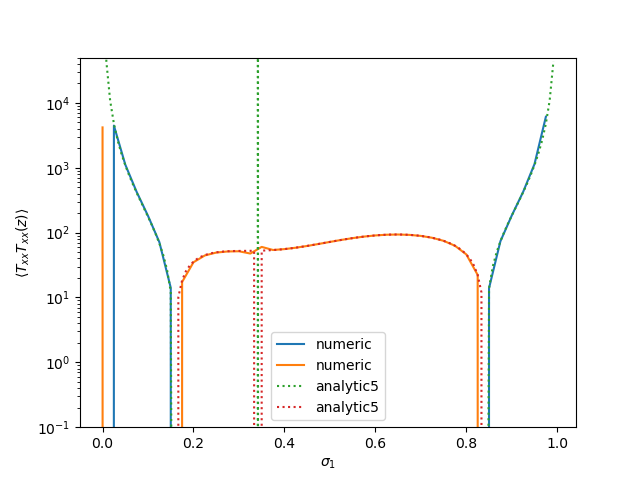

In [314]:
plt.close()

plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], -TxxEE.T[2][:int(Lx/3)], label="numeric")
plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], TxxEE.T[2][:int(Lx/3)], label="numeric")
# plt.plot( Tepseps2.T[0][:Lx], np.real(2.0*Tepseps2.T[2][:Lx]), label="analytic2", ls="dashed")
# plt.plot( Tepseps_6.T[0][:Lx], np.real(2.0*Tepseps_6.T[2][:Lx]), label="analytic6", ls="dashed")

plt.plot( Tepseps_5.T[0][:Lx], np.real(2.0*Tepseps_5.T[2][:Lx]), label="analytic5", ls="dotted")
plt.plot( Tepseps_5.T[0][:Lx], np.real(-2.0*Tepseps_5.T[2][:Lx]), label="analytic5", ls="dotted")

# plt.plot( Tepseps_5.T[0][:Lx], np.real(2.0*Tepseps_51.T[2][:Lx]), label="analytic5", ls="dotted")
# plt.plot( Tepseps_5.T[0][:Lx], np.real(-2.0*Tepseps_51.T[2][:Lx]), label="analytic5", ls="dotted")

# plt.ylim(1e4,2.0e8)
plt.ylim(1e-1,5.0e4)
# plt.xlim(1.0/Lx, 0.3)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
# plt.xscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

/tmp/ipykernel_93353/3851078341.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(TxxEE.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_93353/3851078341.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(-TxxEE.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_93353/3851078341.py:25: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(2.0*np.real(Tepseps_5.T[2])),
/tmp/ipykernel_93353/3851078341.py:27: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(-2.0*np.real(Tepseps_5.T[2])),


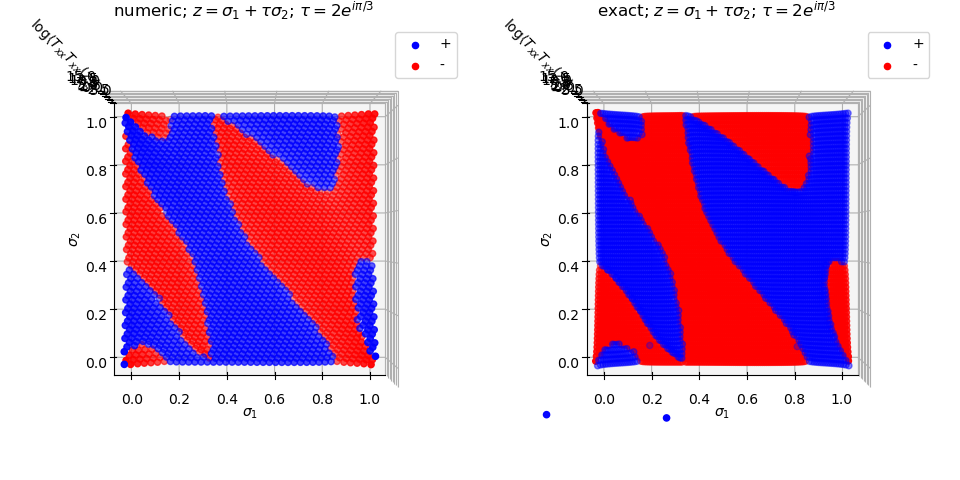

In [313]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(TxxEE.T[2]), c='b', marker='o', label="+")
ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(-TxxEE.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim(-5.0, 15.0)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(2.0*np.real(Tepseps_5.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(-2.0*np.real(Tepseps_5.T[2])), 
           c='r', marker='o', label="-")
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim(-5.0, 15.0)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

In [37]:
tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
z1=np.array(np.split(tmp2, tmp2.shape[0]/3))

tmp = np.array([[ [xx, yy, zeta(xx+tau*yy)-2.0*eta1*(xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp3 = tmp.flatten()
z2=np.array(np.split(tmp3, tmp3.shape[0]/3))

/tmp/ipykernel_85824/2694289963.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ]
/tmp/ipykernel_85824/2694289963.py:1: RuntimeWarning: invalid value encountered in scalar divide
  tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ]


NameError: name 'Tepseps1' is not defined

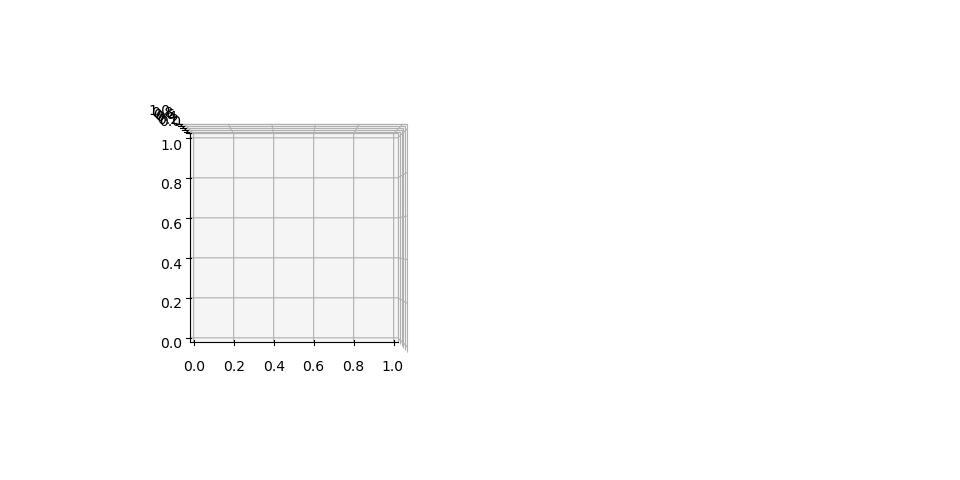

In [38]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(z1.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(z1.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(2.0*np.real(z2.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(z2.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_85824/848327153.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(Tepseps1.T[2])),
/tmp/ipykernel_85824/848327153.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(Tepseps1.T[2])),
/tmp/ipykernel_85824/848327153.py:28: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(Tepseps2.T[2])),


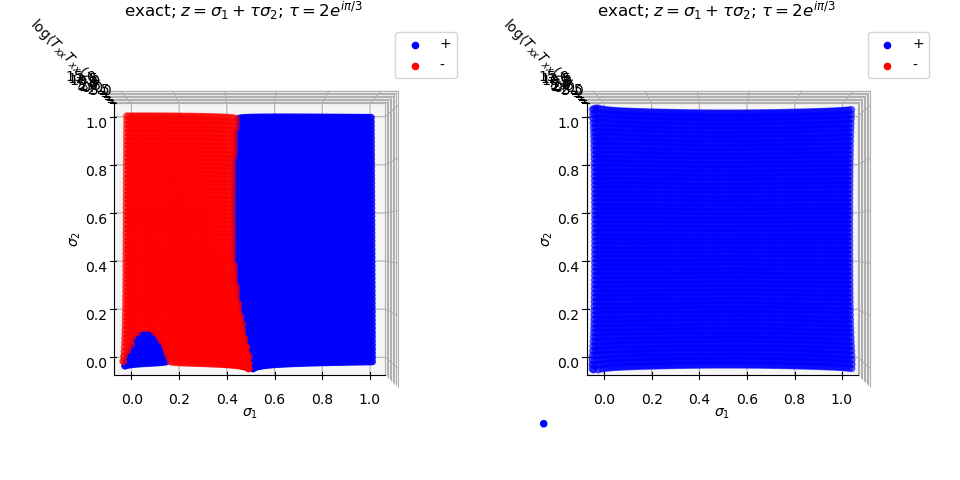

In [55]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(Tepseps1.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(Tepseps1.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(2.0*np.real(Tepseps2.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(Tepseps2.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

In [ ]:
# tmp = np.array([[ [xx, yy, (P(0.5) + 2.0*eta1 + P(xx+tau*yy) + 2.0*eta1) * np.abs( P3(xx+tau*yy-0.5) )**2 ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()

# tmp = np.array([[ [xx, yy, ( -zeta(xx+tau*yy) + 2.0*eta1*( xx+tau*yy ) + np.pi*1.0j) * dP3(xx+tau*yy-0.5)*np.conj(P3(xx+tau*yy-0.5)) ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp3 = tmp.flatten()

# tmp = np.array([[ [xx, yy, -( -zeta(0.5) + 2.0*eta1*(0.5) + np.pi*1.0j) * dP3(xx+tau*yy-0.5)*np.conj(P3(xx+tau*yy-0.5)) ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp4 = tmp.flatten()

# Tepseps_analytic=np.array(np.split(tmp2-tmp3-tmp4, tmp2.shape[0]/3))

In [63]:
Lx/3

32.0

In [62]:
K0EE.T[0][:K]

array([0., 3., 6.])

In [64]:
(K0EE.T[0]/Lx)[:int(Lx/3)]

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875])

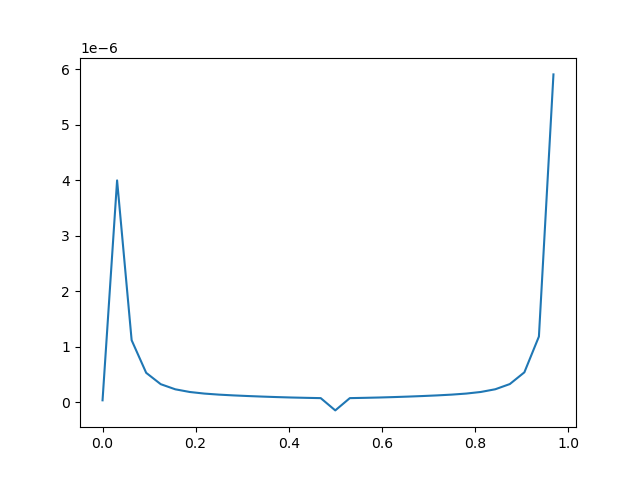

In [73]:
plt.close()
plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], TxxEE.T[2][:int(Lx/3)], label="numeric")

/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/1222106520.py:25: RuntimeWarning: invalid value encountered in log

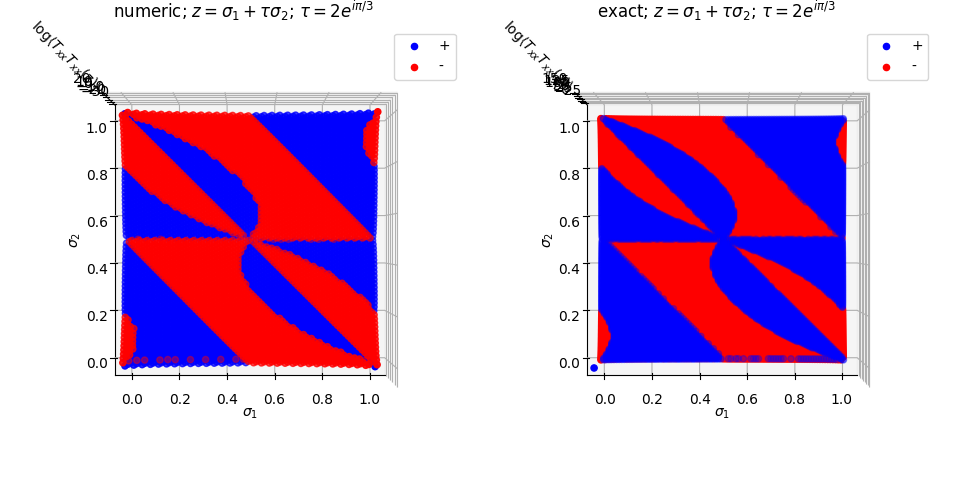

In [69]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/3324861242.py:26: RuntimeWarning: invalid value encountered in log

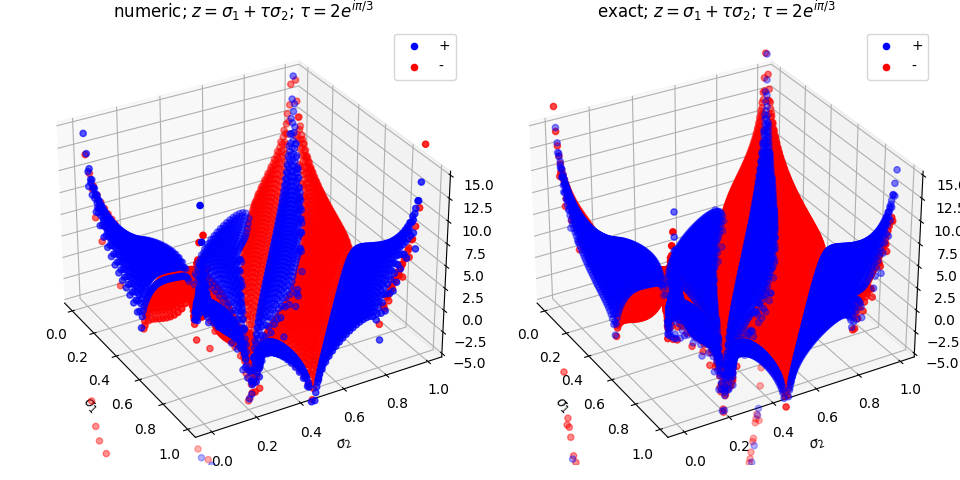

In [70]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

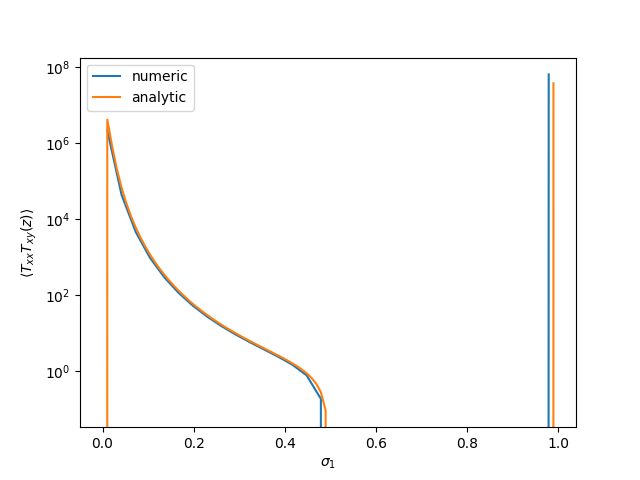

In [71]:
plt.close()

plt.plot( K0K0.T[0][int(Lx/3):2*int(Lx/3)]/Lx, TnxxTnxy.T[2][int(Lx/3):2*int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], -2.0 * np.imag(TTconn_analytic.T[2][Lx:2*Lx]), label="analytic")

# plt.ylim(1.0,1.0e6)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xy}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

# subs

In [ ]:
Lxeff = int(2*Lx/3)
def rearrange(input):
    res_ = [] 
    for i in range(int(input.shape[0]/Lxeff)):
        tmp = input[i*Lxeff:(i+1)*Lxeff]
        reg = tmp.T[2][:-int((i+1)/3)]
        wrap = tmp.T[2][-int((i+1)/3):]
        sign = -1
        if i<=2: sign*=-1
        new = np.concatenate((sign*wrap, reg), axis=0)
        ordered = np.array([ tmp.T[0], tmp.T[1], new ]).T
        res_.append(ordered)
    res = np.array(res_)
    return res

In [44]:
def f_ell1(tau1, tau2):
    return np.sqrt( (1.0+tau1)**2 + tau2**2 )
def f_ell0(tau1, tau2):
    return np.sqrt( (1.0-2.0*tau1)**2 + 4.0*tau2**2 )
def f_ell2(tau1, tau2):
    return np.sqrt( (-2.0+tau1)**2 + tau2**2 )

In [45]:
tau1, tau2 = np.real(tau), np.imag(tau)

In [46]:
print( f_ell0(tau1, tau2) - Ell[0], f_ell1(tau1, tau2) - Ell[1], f_ell2(tau1, tau2) - Ell[2] )

0.0 6.661338147750939e-16 0.0


In [47]:
def f_kappa0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell0 / (v_ell0 + v_ell1 + v_ell2)

def f_kappa1(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell1 / (v_ell0 + v_ell1 + v_ell2)

def f_kappa2(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)
    return 2.0*v_ell2 / (v_ell0 + v_ell1 + v_ell2)

In [48]:
print( f_kappa0(tau1, tau2) - kappa[0], f_kappa1(tau1, tau2) - kappa[1], f_kappa2(tau1, tau2) - kappa[2] )

0.0 0.0 0.0


In [49]:
def d1f_ell1(tau1, tau2):
    v_ell1 = f_ell1(tau1, tau2)
    return 1.0/v_ell1 * (1.0+tau1)

def d2f_ell1(tau1, tau2):
    v_ell1 = f_ell1(tau1, tau2)
    return 1.0/v_ell1 * tau2

def d1f_ell0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    return -2.0/v_ell0 * (1.0-2.0*tau1)

def d2f_ell0(tau1, tau2):
    v_ell0 = f_ell0(tau1, tau2)
    return 1.0/v_ell0 * 4.0*tau2

def d1f_ell2(tau1, tau2):
    v_ell2 = f_ell2(tau1, tau2)
    return 1.0/v_ell2 * (-2.0+tau1)

def d2f_ell2(tau1, tau2):
    v_ell2 = f_ell2(tau1, tau2)
    return 1.0/v_ell2 * tau2

In [50]:
eps = 1.0e-7
print( ( f_ell0(tau1+eps, tau2) - f_ell0(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell0(tau1, tau2) )
print( ( f_ell0(tau1, tau2+eps) - f_ell0(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell0(tau1, tau2) )

print( ( f_ell1(tau1+eps, tau2) - f_ell1(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell1(tau1, tau2) )
print( ( f_ell1(tau1, tau2+eps) - f_ell1(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell1(tau1, tau2) )

print( ( f_ell2(tau1+eps, tau2) - f_ell2(tau1-eps, tau2) ) / (2.0*eps) - d1f_ell2(tau1, tau2) )
print( ( f_ell2(tau1, tau2+eps) - f_ell2(tau1, tau2-eps) ) / (2.0*eps) - d2f_ell2(tau1, tau2) )

-1.1867046789681979e-09
1.362522095149643e-09
-6.448667155822818e-10
2.1377832837288224e-10
8.975865606331013e-10
1.4034124973250073e-09


In [51]:
d1f_ell0(tau1, tau2) + d1f_ell1(tau1, tau2) + d1f_ell2(tau1, tau2)

-0.598986596055108

In [52]:
d2f_ell0(tau1, tau2) + d2f_ell1(tau1, tau2) + d2f_ell2(tau1, tau2)

3.191559007427306

In [53]:
def d1f_kappa0(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell0 - v_ell0*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa0(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell0 - v_ell0*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d1f_kappa1(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell1 - v_ell1*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa1(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell1 - v_ell1*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d1f_kappa2(tau1, tau2):
    dv_ell0 = d1f_ell0(tau1, tau2)
    dv_ell1 = d1f_ell1(tau1, tau2)
    dv_ell2 = d1f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell2 - v_ell2*dsum/sum
    tmp *= 2.0/sum

    return tmp

def d2f_kappa2(tau1, tau2):
    dv_ell0 = d2f_ell0(tau1, tau2)
    dv_ell1 = d2f_ell1(tau1, tau2)
    dv_ell2 = d2f_ell2(tau1, tau2)

    v_ell0 = f_ell0(tau1, tau2)
    v_ell1 = f_ell1(tau1, tau2)
    v_ell2 = f_ell2(tau1, tau2)

    sum = v_ell0+v_ell1+v_ell2
    dsum = dv_ell0+dv_ell1+dv_ell2

    tmp = dv_ell2 - v_ell2*dsum/sum
    tmp *= 2.0/sum

    return tmp

In [54]:
eps = 1.0e-4
print( ( f_kappa0(tau1+eps, tau2) - f_kappa0(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa0(tau1, tau2) )
print( ( f_kappa0(tau1, tau2+eps) - f_kappa0(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa0(tau1, tau2) )

print( ( f_kappa1(tau1+eps, tau2) - f_kappa1(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa1(tau1, tau2) )
print( ( f_kappa1(tau1, tau2+eps) - f_kappa1(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa1(tau1, tau2) )

print( ( f_kappa2(tau1+eps, tau2) - f_kappa2(tau1-eps, tau2) ) / (2.0*eps) - d1f_kappa2(tau1, tau2) )
print( ( f_kappa2(tau1, tau2+eps) - f_kappa2(tau1, tau2-eps) ) / (2.0*eps) - d2f_kappa2(tau1, tau2) )

5.749496573281832e-10
6.580874734041231e-10
-7.49701634106259e-10
-2.683880617748713e-10
1.7475199065586366e-10
-3.896995226515543e-10


In [55]:
d1k0 = d1f_kappa0(tau1, tau2)
d1k1 = d1f_kappa1(tau1, tau2)
d1k2 = d1f_kappa2(tau1, tau2)

d2k0 = d2f_kappa0(tau1, tau2)
d2k1 = d2f_kappa1(tau1, tau2)
d2k2 = d2f_kappa2(tau1, tau2)

In [56]:
matT = np.array([
    [Tn0Tn0,Tn0Tn1,Tn0Tn2],
    [Tn1Tn0,Tn1Tn1,Tn1Tn2],
    [Tn2Tn0,Tn2Tn1,Tn2Tn2]
])

In [57]:
d1k0+d1k1+d1k2, d2k0+d2k1+d2k2

(0.0, 1.1102230246251565e-16)

In [64]:
matd1 = np.array([
    [d1k0*d1k0, d1k0*d1k1, d1k0*d1k2],
    [d1k1*d1k0, d1k1*d1k1, d1k1*d1k2],
    [d1k2*d1k0, d1k2*d1k1, d1k2*d1k2]
])

matd2 = np.array([
    [d2k0*d2k0, d2k0*d2k1, d2k0*d2k2],
    [d2k1*d2k0, d2k1*d2k1, d2k1*d2k2],
    [d2k2*d2k0, d2k2*d2k1, d2k2*d2k2]
])

matd21 = np.array([
    [d2k0*d1k0, d2k0*d1k1, d2k0*d1k2],
    [d2k1*d1k0, d2k1*d1k1, d2k1*d1k2],
    [d2k2*d1k0, d2k2*d1k1, d2k2*d1k2]
])

In [65]:
matd1

array([[ 0.00618705, -0.02198536,  0.01579831],
       [-0.02198536,  0.07812381, -0.05613845],
       [ 0.01579831, -0.05613845,  0.04034014]])

In [66]:
TnxxTnxx = (Ntri*np.pi)**2 * np.sum( np.array([[ matT[i][j]*matd2[i][j] for i in {0,1,2}] for j in {0,1,2} ]), axis=(0,1) )
TnxxTnxy = (Ntri*np.pi)**2 * np.sum( np.array([[ matT[i][j]*matd21[i][j] for i in {0,1,2}] for j in {0,1,2} ]), axis=(0,1) )
TnxyTnxy = (Ntri*np.pi)**2 * np.sum( np.array([[ matT[i][j]*matd1[i][j] for i in {0,1,2}] for j in {0,1,2} ]), axis=(0,1) )

In [68]:
def getSiteXYShifted( params1_ ):
    dalA, fact = params1_
    tildeEllstar0 = fact * np.array([np.cos(alA+dalA), np.sin(alA+dalA)])
    Delta = tildeEllstar0 - ellstar[0]
    tildeEllstar1 = ellstar[1] + Delta
    tildeEllstar2 = ellstar[2] + Delta
    
    type2Shifted = np.array( [type2.T[2], type2.T[3] ] ).T + Delta*alat
    res_ = []
    for i in range(type0.shape[0]):
        res_.append( [type0[i][2], type0[i][3]] )
        res_.append( [type2Shifted[i][0], type2Shifted[i][1]] )
    res = np.array(res_)
    return res

In [69]:
XYs = getSiteXYShifted( [0.0, Ellstar[0]] ) # np.array([xlat, ylat]).T
TTconn_analytic = np.array([ TTconn3(elem[0]+1.0j*elem[1] - src_cplx ) for elem in XYs] )

/tmp/ipykernel_742803/2347581120.py:12: RuntimeWarning: invalid value encountered in log
  ax.scatter( xlat[::2], ylat[::2], np.log( TnxxTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
/tmp/ipykernel_742803/2347581120.py:19: RuntimeWarning: invalid value encountered in log
  np.log( np.imag(TTconn_analytic) ),


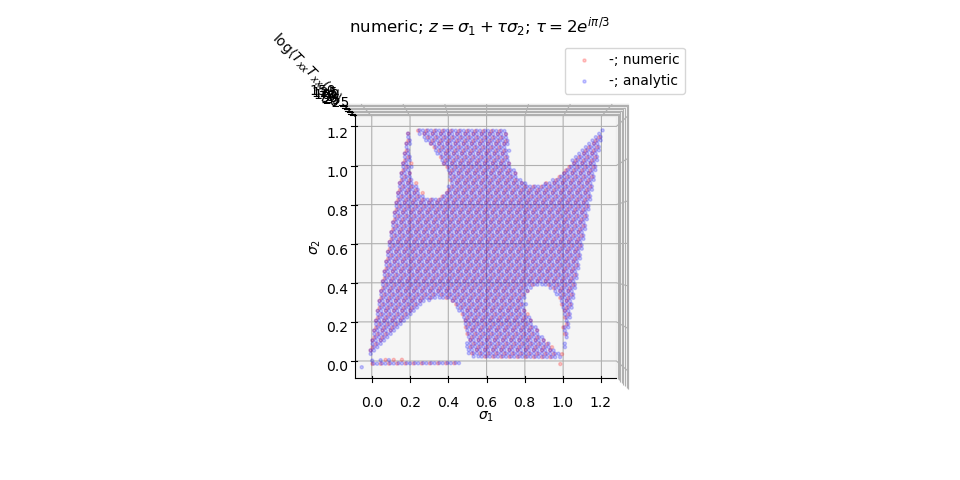

In [71]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter( xlat[1::2], ylat[1::2], np.log(-TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
# ax.scatter( xlat[::2], ylat[::2], np.log( TnxyTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
# ax.scatter( xlat[::2], ylat[::2], np.log( TnxxTnxx.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter( xlat[::2], ylat[::2], np.log( TnxxTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)

# ax.scatter(XYs.T[0], XYs.T[1], 
#            np.log( -np.real(TTconn_analytic) ),
#            # np.log( -mixing( [np.real(TTconn_analytic), np.imag(TTconn_analytic)], -np.pi/2.0) ), 
#            c='b', marker='.', label="-; analytic", alpha=0.2)
ax.scatter(XYs.T[0], XYs.T[1], 
           np.log( np.imag(TTconn_analytic) ),
           # np.log( -mixing( [np.real(TTconn_analytic), np.imag(TTconn_analytic)], -np.pi/2.0) ), 
           c='b', marker='.', label="-; analytic", alpha=0.2)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
plt.savefig('../TxxTxx_G'+str(Lx)+'.pdf',bbox_inches='tight')

/tmp/ipykernel_742803/900430561.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter( xlat, ylat, np.log( TnxyTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3456,) and arg 2 with shape (1728,).

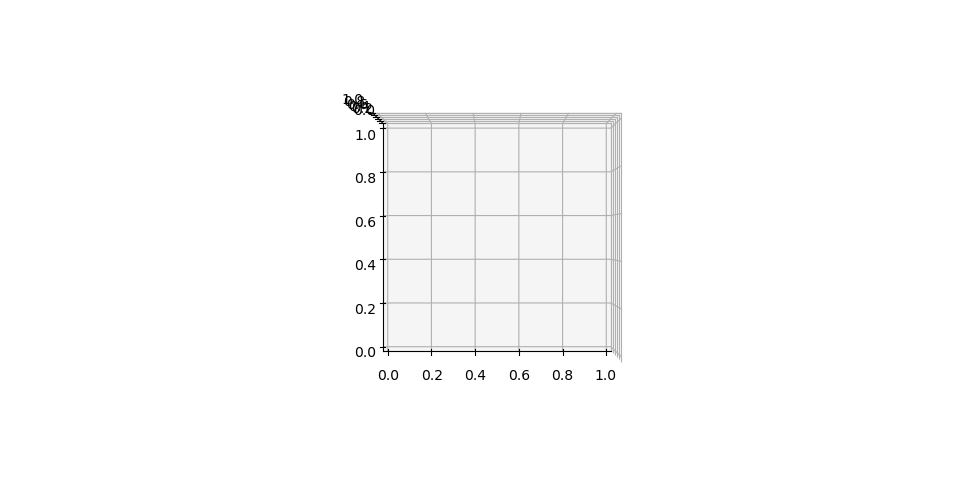

In [70]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter( xlat[1::2], ylat[1::2], np.log(-TTs[Mu]), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter( xlat, ylat, np.log( TnxyTnxy.T[2] ), c='r', marker='.', label="-; numeric", alpha=0.2)
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
           np.log( -mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, -np.pi/2.0) ), 
           c='b', marker='.', label="-; analytic", alpha=0.2)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

#################

fig.tight_layout()
plt.savefig('../TxxTxx_G'+str(Lx)+'.pdf',bbox_inches='tight')

In [107]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# angle = alC + np.pi + 2.0*np.arccos(e[0][0]) # 0.24 * np.pi

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=-90)

# # ax.scatter( xlat[::], ylat[::], np.log(-TnCTnC.T[2]), c='b', marker='o', label="-", alpha=0.3)
# ax.scatter( xlat[1::2], ylat[1::2], np.log(TnCTnC.T[2])[::], c='r', marker='.', label="+", alpha=0.3)

# ax.legend()
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("${\\rm log} \\langle T_{2}T_{2}(z) \\rangle$")
# ax.set_title("numeric; $\\tau = $"+'{:.3f}'.format(tau)+"; L="+str(Lx))



# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=-90)

# # ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
# #            np.log( -mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle ) ), 
# #            c='b', marker='o', label="-", alpha=0.3)
# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], 
#            np.log( mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle ) ), 
#            c='r', marker='.', label="+", alpha=0.3)


# ax.legend()
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("${\\rm log} \\langle T_{2}T_{2}(z) \\rangle$")
# ax.set_title("exact; $\\tau = $"+'{:.3f}'.format(tau)+"; L="+str(Lx) )
# ax.set_zlim( 0, 20 )

# #################

# #################

# fig.tight_layout()
# # plt.savefig('../T2T2.pdf',bbox_inches='tight')

In [136]:
# plt.close()

# angle = alA # 0.24 * np.pi
# mix = mixing( [np.real(TTconn_analytic.T[2]), np.imag(TTconn_analytic.T[2])], 1.0, angle )

# plt.plot( K0K0.T[0][:int(Lx/3)]/Lx, TnATnA.T[2][:int(Lx/3)], label="numeric")
# # plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.real(TTconn_analytic.T[2][:Lx]), label="analytic")
# plt.plot( TTconn_analytic.T[0][:int(Lx)], 
#          0.3*mix[:int(Lx)],
#          label="analytic")

# plt.ylim(1.0,1.0e8)
# plt.legend()

# plt.xlabel("$\\sigma_1$")
# plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

# plt.yscale("log")
# # plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')